<a href="https://colab.research.google.com/github/IsaVillarejo/repositorio-tfm/blob/main/TFM_SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python --version

Python 3.12.11


In [ ]:
#LIBRERIAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#CARGA DATOS INICIAL

In [ ]:
# Nos aseguramos que tenemos instalada la última versión de la API de Kaggle en Colab
!pip install --upgrade --force-reinstall --no-deps kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.5
    Uninstalling kaggle-1.7.4.5:
      Successfully uninstalled kaggle-1.7.4.5


In [ ]:
# Seleccionar el API Token personal previamente descargado desde kaggle (fichero kaggle.json)
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"isabelvi","key":"572b0ec345751c342a13052630fae2ae"}'}

In [ ]:
# Creamos un directorio en el que copiamos el fichero kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#Aceptadas las reglas de competición de Kaggle, descarguemos el dataset correspondiente
!kaggle competitions download -c ieee-fraud-detection


 95% 112M/118M [00:00<00:00, 1.17GB/s]
100% 118M/118M [00:00<00:00, 1.12GB/s]


In [ ]:
# Creemos un directorio para descomprimir los datos
!mkdir /content/ieee-fraud-detection.zip

# Descomprimimos los datos y los dejamos listos para trabajar
!unzip ieee-fraud-detection.zip -d my_dataset

mkdir: cannot create directory ‘/content/ieee-fraud-detection.zip’: File exists
Archive:  ieee-fraud-detection.zip
  inflating: my_dataset/sample_submission.csv  
  inflating: my_dataset/test_identity.csv  
  inflating: my_dataset/test_transaction.csv  
  inflating: my_dataset/train_identity.csv  
  inflating: my_dataset/train_transaction.csv  


In [ ]:
train_trans = pd.read_csv('/content/my_dataset/train_transaction.csv')

In [ ]:
test_trans = pd.read_csv('/content/my_dataset/test_transaction.csv')

In [ ]:
train_id = pd.read_csv('/content/my_dataset/train_identity.csv')

In [ ]:
test_id = pd.read_csv('/content/my_dataset/test_identity.csv')

Número de filas y columnas:

In [ ]:
train_trans.shape
#(590540, 394)

(590540, 394)

In [ ]:
test_trans.shape

Tenemos 393 caracteristicas (mas la etiqueta, fraude o no). En el entrenamiento se tienen 590540 instancias y 506691 en el test.

In [ ]:
train_id.shape

In [ ]:
test_id.shape

In [ ]:
train_trans.head()

In [ ]:
train_id.head()

#DESCRIPTIVO

El objetivo es predecir la probabilidad de que una transacción en línea sea fraudulenta.

Los datos se dividen en dos archivos identity y transaction, que se unen mediante TransactionID. No todas las transacciones tienen la información de identidad correspondiente.

Tabla de transacciones: contiene transferencias de dinero y también otros regalos de bienes y servicios, como reservar un boleto para otras personas, etc.

- TransactionDT: timedelta de una fecha y hora de referencia dada (no una marca de tiempo real).


- TransactionAMT: importe del pago de la transacción en USD.

- ProductCD: código del producto, el producto para cada transacción.(variable categórica)

- card1 - card6: información de la tarjeta de pago, como tipo de tarjeta, categoría de tarjeta, banco emisor, país, etc. (variables categóricas)

- addr1 y addr2: direcciones
(ambas direcciones son para el comprador
addr1 como región de facturación
addr2 como país de facturación) (variables categóricas)

- dist: distancia
“distancias entre (no limitadas) dirección de facturación, dirección postal, código postal, dirección IP, área telefónica, etc.”

P_ y (R__) emaildomain: dominio de correo electrónico del comprador y del destinatario
“ciertas transacciones no necesitan destinatario, por lo que R_emaildomain es nulo.” (variables categoricas)

C1-C14: recuento, como cuántas direcciones se encuentran asociadas con la tarjeta de pago, etc. El significado real está enmascarado.

D1-D15: timedelta, como días entre transacciones anteriores, etc.

M1-M9: coincidencia, como nombres en la tarjeta y dirección, etc. (variables categóricas)

Vxxx: Vesta diseñó funciones avanzadas, que incluyen clasificación, conteo y otras relaciones entre entidades.
"Por ejemplo, cuántas veces apareció la tarjeta de pago asociada a una IP, correo electrónico o dirección en un intervalo de 24 horas, etc."




In [ ]:
#comprobar las variables no numericas
train_trans.select_dtypes(exclude=['number']).columns

Tabla de identidad

Las variables de esta tabla son información de identidad: información de conexión de red (IP, ISP, proxy, etc.) y firma digital (UA/navegador/sistema operativo/versión, etc.) asociadas a las transacciones.
Estas variables son recopiladas por el sistema de protección contra fraudes de Vesta y sus socios de seguridad digital.
(Los nombres de los campos están enmascarados y no se proporcionará un diccionario por pares para proteger la privacidad y garantizar la conformidad contractual).

Características categóricas:
Tipo de dispositivo, Información del dispositivo,id_12 - id_38

In [ ]:
#comprobar las variables no numericas
train_id.select_dtypes(exclude=['number']).columns

## Union de las tablas

In [ ]:
#Unión por la columna "TransactionID", manteniendo todas las filas de train_trans y de test_trans
train = train_trans.merge(train_id, on='TransactionID', how='left')
test = test_trans.merge(test_id, on='TransactionID', how='left')


In [ ]:
train.shape

In [ ]:
test.shape

# Gráfico de variables

VARIABLE OBJETIVO

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='isFraud', data=train)
plt.title('Distribución de la variable objetivo (isFraud)')
plt.xlabel('¿Fraude?')
plt.ylabel('Cantidad de transacciones')
plt.show()

Como era de esperar hay muchos menos casos de Fraud que de no Fraud. Veamos en concreto la proporción

In [ ]:
print(train['isFraud'].value_counts())

# Proporciones
print("\nProporciones:")
print(train['isFraud'].value_counts(normalize=True))

Este desbalanceo tendrá que ser tratado mas adelante

CANTIDAD DE TRANSACCIONES (según si es Fraude o no)

- TRANSACTION AMT

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.histplot(train, x='TransactionAmt', bins=50, kde=True, hue='isFraud', element='step')
plt.title('Distribución de TransactionAMT según fraude')
plt.show()


In [ ]:
train['TransactionAmt'].median()

Parece que hay outliers que dificultan la visualización, por ello se ha limitado el rango usando solo los valores por debajo del percentil 99



In [ ]:
p99 = train['TransactionAmt'].quantile(0.99)

plt.figure(figsize=(12,6))
sns.histplot(train[train['TransactionAmt'] < p99], x='TransactionAmt', bins=50, kde=True, hue='isFraud', element='step')
plt.title('Distribución de TransactionAmt (por debajo del percentil 99) según fraude')
plt.show()


DISTANCIAS (dist1):

Histograma o boxplot, para ver si hay diferencias entre fraude/no fraude.

In [ ]:
# Histograma dist1
plt.figure(figsize=(12,6))
sns.histplot(data=train, x='dist1', bins=50, hue='isFraud', kde=True, element='step', palette='Set2')
plt.title('Distribución de dist1 según fraude')
plt.show()

# Boxplot dist1
plt.figure(figsize=(8,5))
sns.boxplot(x='isFraud', y='dist1', data=train, palette='Set2')
plt.title('Boxplot de dist1 por fraude')
plt.show()



In [ ]:
#mas cerca
plt.figure(figsize=(12,6))
sns.histplot(train[train['dist1'] < 100], x='dist1', bins=50, kde=True, hue='isFraud', element='step')
plt.title('Distribución de dist1 < 100 según fraude')
plt.show()

**VARIABLES CATEGÓRICAS**

In [ ]:
train.select_dtypes(exclude=['number']).columns

Veamos cuantos valores únicos hay por cada variable categórica

In [ ]:
cat_cols = train.select_dtypes(exclude=['number']).columns

for col in cat_cols:
    print(f"{col}: {train[col].nunique()} categorías")


Graficamos estas distinguiendo entre fraude y no fraude

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in cat_cols:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=train, x=col, order=train[col].value_counts().iloc[:10].index, hue='isFraud')
    plt.title(f'Distribución de {col} (Top 10) según fraude')
    plt.xticks(rotation=45)
    plt.legend(title='isFraud', labels=['No Fraude', 'Fraude'])
    plt.tight_layout()
    plt.show()


In [ ]:
for col in cat_cols:
    print(f"\Cantidad de fraude por categoría en {col}:")
    print(train.groupby(col)['isFraud'].sum().sort_values(ascending=False))

Para ver mejor la proporción de fraude en cada categoría de las variables categóricas:

In [ ]:
for col in cat_cols:
    print(f"\nProporción de fraude por categoría en {col}:")
    print(train.groupby(col)['isFraud'].mean().sort_values(ascending=False))

El producto que mas aparece es W y por ser el más frecuente es en el que más caso de fraude hay. Sin embargo, no es el que mayor proporción de fraude presenta, al contrario, es el que menos. Mientras que la mayor proporción de fraude la presenta el producto C.

La tarjeta más usada es VISA, pero es Discover, la menos usada, la que presnta mayor proporción de casos de fraude y aunque las de débito son las más usadas, las de crédito triplican la proporción de fraude

En cuanto al P_emaildomain (dominio del mail del comprador), solo hay 31 de protonmail.com pero el 40% son fraude. gmail.com, hotmail.com y yahoo.com son los dominios mas frecuentes con proporciones de fraude 0.043542, 0.052950,  0.022757

Respecto al R_emaildomain (dominio del mail del destinatario) el 95% de los correos con ese dominio son fraude, aunque solo haya 39 datos, el porcentaje es muy alto

## Correlacion

In [ ]:
#matriz de correlacion
corr_matrix = train.corr(numeric_only=True)

#heatmap
plt.figure(figsize=(16,12))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False, fmt=".2f", linewidths=0.5)
plt.title('Mapa de calor de correlación entre variables')
plt.show()

In [ ]:
#  columnas
cols = list(train.columns)

# posición de 'C13' e 'isFraud'
c13_index = cols.index('C13')
d1_index = cols.index('D1')
d15_index = cols.index('D15')
m1_index = cols.index('M1')
m9_index = cols.index('M9')
v1_index = cols.index('V1')
v91_index = cols.index('V91')
isFraud_index = cols.index('isFraud')

# Primer bloque: desde el principio hasta V91 (inclusive), más isFraud
cols_part1 = cols[:c13_index+1] + ['isFraud'] if 'isFraud' not in cols[:c13_index+1] else cols[:c13_index+1]
cols_part2 = cols[d1_index:d15_index+1] + ['isFraud'] if 'isFraud' not in cols[d1_index:d15_index+1] else cols[d1_index:d15_index+1]
cols_part3 = cols[m1_index:m9_index+1] + ['isFraud'] if 'isFraud' not in cols[m1_index:m9_index+1] else cols[m1_index:m9_index+1]
cols_part4 = cols[v1_index:v91_index+1] + ['isFraud'] if 'isFraud' not in cols[v1_index:v91_index+1] else cols[v1_index:v91_index+1]

# Segundo bloque: desde después de V91 hasta el final, asegurando que isFraud esté incluido
#cols_part = cols[v91_index+1:] if 'isFraud' not in cols[v91_index+1:] else [col for col in cols[v91_index+1:] if col != 'isFraud']
#cols_part += ['isFraud']

In [ ]:
corr1 = train[cols_part1].corr(numeric_only=True)

# Crear máscara para la mitad superior
mask = np.triu(np.ones_like(corr1, dtype=bool))

# Inicializar el gráfico
f, ax = plt.subplots(figsize=(18, 14))

# Dibujar heatmap con anotaciones solo en la mitad superior
sns.heatmap(corr1, mask=~mask, cmap='coolwarm', center=0,
            annot=True, fmt=".2f", linewidths=.5, cbar_kws={"shrink": .5})

# Dibujar solo colores en la mitad inferior
sns.heatmap(corr1, mask=mask, cmap='coolwarm', center=0,
            annot=False, linewidths=.5, cbar=False)

plt.title('Matriz de correlación (hasta C13)', fontsize=16)
plt.show()

In [ ]:
corr2 = train[cols_part2].corr(numeric_only=True)

# Crear máscara para la mitad superior
mask = np.triu(np.ones_like(corr2, dtype=bool))

# Inicializar el gráfico
f, ax = plt.subplots(figsize=(18, 14))

# Dibujar heatmap con anotaciones solo en la mitad superior
sns.heatmap(corr2, mask=~mask, cmap='coolwarm', center=0,
            annot=True, fmt=".2f", linewidths=.5, cbar_kws={"shrink": .5})

# Dibujar solo colores en la mitad inferior
sns.heatmap(corr2, mask=mask, cmap='coolwarm', center=0,
            annot=False, linewidths=.5, cbar=False)

plt.title('Matriz de correlación (desde D1 hasta D15)', fontsize=16)
plt.show()

CON COLS_PART3 NO TIENE SENTIDO VER CORRRELACION PORQUE M1-M9 SON CATEGORICAS, NO NUMERICAS

In [ ]:
corr4 = train[cols_part4].corr(numeric_only=True)

# Crear máscara para la mitad superior
mask = np.triu(np.ones_like(corr4, dtype=bool))

# Inicializar el gráfico
f, ax = plt.subplots(figsize=(30, 26))

# Dibujar heatmap con anotaciones solo en la mitad superior
sns.heatmap(corr4, mask=~mask, cmap='coolwarm', center=0,
            annot=True, fmt=".2f", linewidths=.5, cbar_kws={"shrink": .5})

# Dibujar solo colores en la mitad inferior
sns.heatmap(corr4, mask=mask, cmap='coolwarm', center=0,
            annot=False, linewidths=.5, cbar=False)

plt.title('Matriz de correlación (desde V1 hasta V91)', fontsize=16)
plt.show()

ES INVIABLE MOSTRAR LA CORRELACION DE V1 A V339 EN UN HEATMAP VOY A INTENAR VER LAS VARIABLES MAS CORRELACIONADAS

In [ ]:
v1_index = cols.index('V1')
v339_index = cols.index('V339')
cols_v = cols[v1_index:v339_index+1]

In [ ]:
corr_matrix = train[cols_v].corr()
# Crear un dataframe de pares con correlación > 0.8
high_corr = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
high_corr.columns = ['var1', 'var2', 'correlation']
high_corr = high_corr[high_corr['correlation'].abs() > 0.8]
print(high_corr)

In [ ]:
import pandas as pd

# Mostrar todas las filas
pd.set_option('display.max_rows', None)

# Si quieres ver todas las columnas también
pd.set_option('display.max_columns', None)

# Ahora imprime tu dataframe
print(high_corr)


VARIABLES A ELIMINAR

In [ ]:
# Lista de variables a eliminar
variables_a_eliminar = [
    "TransactionDT",
    "C2", "C4", "C6", "C7", "C8", "C10", "C11", "C12", "C13",
    "C9" ,
    "D2", "D12", "D6", "D7", "D11", "D15",
    "V4", "V8", "V11", "V29", "V30", "V48", "V49", "V69", "V70", "V90", "V91",
    "V13", "V41", "V65", "V88", "V16", "V17", "V18", "V21", "V31", "V32", "V33", "V34",
    "V42", "V43", "V50", "V51", "V52", "V57", "V58", "V59", "V63", "V71", "V72",
    "V73", "V74", "V79", "V84", "V92", "V93", "V94", "V20", "V39", "V60",
    "V64", "V80", "V81", "V85", "V302", "V304", "V24", "V26",
    "V28", "V68", "V89", "V36", "V38", "V45", "V54", "V62", "V67",
    "V76", "V83", "V87", "V96", "V97", "V101", "V102", "V103", "V105",
    "V126", "V127", "V128", "V132", "V133", "V134", "V143", "V164",
    "V165", "V167", "V168", "V177", "V178", "V179", "V202", "V203",
    "V204", "V211", "V212", "V213", "V217", "V218", "V219", "V231",
    "V232", "V233", "V273", "V275", "V279", "V280", "V293", "V294",
    "V295", "V298", "V306", "V307", "V308", "V316", "V317", "V318", "V322",
    "V323", "V324", "V329", "V331", "V332", "V333", "V325", "V100",
    "V285", "V326", "V327", "V106", "V181", "V183", "V235", "V236",
    "V237", "V297", "V299", "V328", "V330", "V311", "V334", "V336", "V335",
    "V312", "V137", "V320", "V338", "V140", "V142", "V145", "V151", "V152", "V159",
    "V160", "V147", "V149", "V153", "V154", "V155", "V156", "V157", "V158", "V162", "V163", "V200",
    "V186", "V191", "V196", "V207", "V190", "V199", "V228", "V182", "V234", "V296",
    "V185", "V192", "V193", "V189", "V195", "V197", "V268",
    "V216", "V276", "V277", "V278", "V319", "V321", "V222", "V245",
    "V259", "V225", "V229", "V248", "V253", "V254", "V261", "V267",
    "V258", "V239", "V244", "V246", "V249",
    "V252", "V251", "V256", "V265", "V274", "V271", "V272",
    "V289", "V292", "V301", "V315", "V339"
]

# Eliminar columnas del DataFrame
train = train.drop(columns=variables_a_eliminar)
test = test.drop(columns=variables_a_eliminar)

print(train.shape)   # para ver dimensiones finales
print(test.shape)
print(train.head())  # para confirmar que ya no aparecen esas variables



(590540, 209)
(506691, 208)
   TransactionID  isFraud  TransactionAmt ProductCD  card1  card2  card3  \
0        2987000        0            68.5         W  13926    NaN  150.0   
1        2987001        0            29.0         W   2755  404.0  150.0   
2        2987002        0            59.0         W   4663  490.0  150.0   
3        2987003        0            50.0         W  18132  567.0  150.0   
4        2987004        0            50.0         H   4497  514.0  150.0   

        card4  card5   card6  ...                id_31  id_32      id_33  \
0    discover  142.0  credit  ...                  NaN    NaN        NaN   
1  mastercard  102.0  credit  ...                  NaN    NaN        NaN   
2        visa  166.0   debit  ...                  NaN    NaN        NaN   
3  mastercard  117.0   debit  ...                  NaN    NaN        NaN   
4  mastercard  102.0  credit  ...  samsung browser 6.2   32.0  2220x1080   

            id_34 id_35 id_36  id_37  id_38  DeviceType  \

## Outliers

In [ ]:
# variables numéricas
numericas_cols = train.select_dtypes(include=['float64', 'int64']).columns
numericas_cols = numericas_cols.drop('isFraud') #quitar isFraud

#guardar outliers detectados
outlier_summary = {}

for col in numericas_cols:
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    #numero de outliers
    outliers = ((train[col] < lower_bound) | (train[col] > upper_bound)).sum()
    total = train[col].notna().sum()
    outlier_summary[col] = round(100 * outliers / total, 2)  # % de outliers

# Mostrar variables con más del 1% de outliers
for col, perc in outlier_summary.items():
    if perc > 1:
        print(f"{col}: {perc}% de outliers")


Aunque hay bastantes outliers, pueden ser datos importantes o infomativos y dado que las redes neuronales no suelen ser sensibles a valores atípicos (si se normalizan adecuadamente), considero que no es conveniente eliminarlos pues sería perder información

# preprocesado

In [ ]:
from multiprocessing import Pool, cpu_count
from collections import defaultdict
from sklearn.cluster import FeatureAgglomeration
from scipy.stats import normaltest, skew
import json

In [ ]:
def patron_faltante(args):
  #Función auxiliar que procesa una columna y su máscara de valores faltantes.
  # Args:
  #        args: Tupla con (nombre_columna, mascara_faltantes)
  # Returns:
  #            Tupla con (nombre_columna, patron_faltantes)
    col, col_mask = args
    return (col, tuple(col_mask))

def columnas_faltantes_juntas(df):
     #Identifica grupos de columnas que siempre tienen valores faltantes en las mismas filas.
     # Args:
     #  df: DataFrame de pandas a analizar
     #Returns:
     #   Lista de listas, donde cada sublista contiene columnas que faltan juntas

    np.random.seed(42)
    indices_aleat = np.random.choice(df.index, size=50000, replace=False)
    # tomamos 50k filas para no perder memoria ni tiempo
    indices_orden = np.sort(indices_aleat) #los ordenamos
    df_muestra = df.loc[indices_orden] #muestra

    #Creamos una máscara booleana que indica dónde hay valores faltantes.
    mask_falta = df_muestra.isna()
    #Eliminar columnas que siempre tienen valores o siempre están faltantes
    mask_filtrada = mask_falta.loc[:, (mask_falta.sum() > 0) & (mask_falta.sum() < len(mask_falta))]
    #nos quedamos con esas columnas
    cols = mask_filtrada.columns

    #procesamiento en paralelo
    with Pool(cpu_count()) as pool:
        patrones_columnas = pool.map(patron_faltante, [(col, mask_filtrada[col].values) for col in cols])
    # Agrupamos columnas por patrones de faltantes idénticos
    grupos_patrones = defaultdict(list)
    for col, patron in patrones_columnas:
        grupos_patrones[patron].append(col)
    # Nos quedamos solo con grupos de 2 o mas columnas que faltan juntas
    col_faltan_juntas = [grupo for grupo in grupos_patrones.values() if len(grupo) > 1]
    # Retorna solo los grupos con más de una columna (columnas que faltan juntas).
    return col_faltan_juntas

#Aplicamos la funcion a train
col_faltan_juntas = columnas_faltantes_juntas(train)
#Imprimimos cada grupo
for group in col_faltan_juntas:
    print("Columnas que faltan juntas:", group)

Columnas que faltan juntas: ['addr1', 'addr2']
Columnas que faltan juntas: ['D1', 'V281', 'V282', 'V283', 'V288', 'V300', 'V313', 'V314']
Columnas que faltan juntas: ['D8', 'D9', 'id_09', 'id_10']
Columnas que faltan juntas: ['M1', 'M2', 'M3']
Columnas que faltan juntas: ['M8', 'M9']
Columnas que faltan juntas: ['V1', 'V2', 'V3', 'V5', 'V6', 'V7', 'V9', 'V10']
Columnas que faltan juntas: ['V12', 'V14', 'V15', 'V19', 'V22', 'V23', 'V25', 'V27']
Columnas que faltan juntas: ['V35', 'V37', 'V40', 'V44', 'V46', 'V47']
Columnas que faltan juntas: ['V53', 'V55', 'V56', 'V61', 'V66']
Columnas que faltan juntas: ['V75', 'V77', 'V78', 'V82', 'V86']
Columnas que faltan juntas: ['V95', 'V98', 'V99', 'V104', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V129', 'V130', 'V131', 'V135', 'V136']
Columnas que faltan juntas: ['V138', 'V139', 'V141', 'V144', 'V146', 'V148', 'V150', 'V161', 'V166']
Co

Antes de agrupar las columnas que faltan juntas, vamos a identificar las variables categoricas porque estas van independientes de esta agrupacion

In [ ]:
categorical_cols = train.select_dtypes(
    include=['object','category']).columns.tolist()
print(categorical_cols)

['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


In [ ]:
test.select_dtypes(
    include=['object','category']).columns.tolist()

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'id-12',
 'id-15',
 'id-16',
 'id-23',
 'id-27',
 'id-28',
 'id-29',
 'id-30',
 'id-31',
 'id-33',
 'id-34',
 'id-35',
 'id-36',
 'id-37',
 'id-38',
 'DeviceType',
 'DeviceInfo']

Observé que tenía problemas porque las variables en test se separaban por guión en lugar de por guión bajo como en train, aunque se referían a lo mismo, así que la cambié

In [ ]:
test.columns = test.columns.str.replace('-', '_')

In [ ]:
def agrupar_columnas_faltantes(df, grupos, categorical_cols, n_clusters=1, max_group_size=20):
  #  Agrupa columnas numéricas con patrones similares de valores faltantes mediante clustering aglomerativo.
  # Parámetros:
  #  df : DataFrame
  #  grupos : Lista de grupos de columnas que faltan juntas (de columnas_faltantes_juntas)
  # columnas_categoricas :   Columnas categóricas que se excluirán del proceso
  #  n_clusters : Número de clusters a crear por grupo
  # tamaño_max_grupo :  Tamaño máximo permitido para procesar un grupo
  # Return:
  #     DataFrame modificado con las nuevas columnas agrupadas

    for i, grupo in enumerate(grupos, 1):
        # # Filtramos solo columnas numéricas del grupo
        numeric_group = [col for col in grupo if col not in categorical_cols]
        #ignorar grupos no validos, que no se van a agrupar
        if len(numeric_group) < 2 or len(numeric_group) > max_group_size:
            continue
        try:
            # Filtrar filas donde al menos una columna del grupo NO sea NaN
            mask = ~df[numeric_group].isna().all(axis=1)
            #si no hay filas con valores, saltamos el grupo
            if mask.sum() == 0:
                continue

            # imputamos en el cluster
            X = df.loc[mask, numeric_group].fillna(df[numeric_group].mean())

            # Aplicamos clustering aglomerativo
            agg = FeatureAgglomeration(n_clusters=n_clusters)
            red = agg.fit_transform(X)

            # Guardar columna aglomerada y borrar originales
            col_nombre = f"A{i}"
            df[col_nombre] = np.nan
            df.loc[mask, col_nombre] = red.ravel()
            df.drop(columns=numeric_group, inplace=True) #eliminamos originales

        except Exception as e:
            print(f"Error en grupo {i} ({numeric_group}): {e}")
            continue

    return df


In [ ]:
train_red = agrupar_columnas_faltantes(train, col_faltan_juntas, categorical_cols)
train_red.head()

,TransactionID,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,A10,A12,A13,A14,A15,A16,A18,A19,A20,A22
0,2987000,0,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,NaN,517.888889,0.428571,0.25,0.428571,0.5625,NaN,NaN,NaN,NaN


In [ ]:
test_red = agrupar_columnas_faltantes(test, col_faltan_juntas, categorical_cols)

In [ ]:
test_red.head()

,TransactionID,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,dist1,...,A10,A12,A13,A14,A15,A16,A18,A19,A20,A22
0,3663549,31.95,W,10409,111.0,150.0,visa,226.0,debit,1.0,...,0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,49.00,W,4272,111.0,150.0,visa,226.0,debit,4.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,171.00,W,4476,574.0,150.0,visa,226.0,debit,2635.0,...,1.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,284.95,W,10989,360.0,150.0,visa,166.0,debit,17.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,6.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#common_cols = list(set(train_red.columns) & set(test_red.columns))

In [ ]:
#numeric_cols = [col for col in common_cols if np.issubdtype(train_red[col].dtype, np.number)]

Transformacion de variables categoricas

In [ ]:
from sklearn.preprocessing import LabelEncoder

for col in categorical_cols:
    train_red[col] = train_red[col].fillna('missing')
    test_red[col] = test_red[col].fillna('missing')

    le = LabelEncoder()
    le.fit(list(train_red[col]) + list(test_red[col]))  # Aprende de ambos datasets, si no me da problemas en test

    train_red[col] = le.transform(train_red[col])
    test_red[col] = le.transform(test_red[col])

# Muestreo

El conjunto de datos es muy grande para algunas operaciones como la posterior imputación de nulos con MICE, por lo que se utilizará una muestra más reducida mediante muestreo estratificado para la proporción de la variable objetivo

In [ ]:
TRAIN_SIZE = 30000

count_NotF, count_F = train_red['isFraud'].value_counts()
prop_F = count_F / (count_NotF + count_F)

num_F = int(TRAIN_SIZE * prop_F)
num_NotF = TRAIN_SIZE - num_F

df_NotF = train_red[train_red['isFraud'] == 0].sample(num_NotF, random_state=42)
df_F = train_red[train_red['isFraud'] == 1].sample(num_F, random_state=42)

train_reducido = pd.concat([df_NotF, df_F]).sample(frac=1, random_state=42)
print(f"Train reducido: {train_reducido.shape}")

Train reducido: (30000, 118)


In [ ]:
train_reducido.head()

,TransactionID,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,A10,A12,A13,A14,A15,A16,A18,A19,A20,A22
531340,3518340,0,280.0,4,13256,583.0,150.0,2,219.0,1,...,0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
510740,3497740,0,141.0,4,6077,555.0,150.0,4,226.0,2,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123893,3110893,0,226.0,4,2616,NaN,150.0,1,102.0,1,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
345621,3332621,0,44.0,4,7815,161.0,150.0,2,117.0,2,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235694,3222694,0,445.0,4,16075,514.0,150.0,2,102.0,1,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#IMPUTAR NULOS CON MICE

In [ ]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_reducido, test_size=0.2, random_state=42)

X_train = train_df.drop('isFraud', axis=1)
y_train = train_df['isFraud']

X_val = val_df.drop('isFraud', axis=1)
y_val = val_df['isFraud']

numeric_cols = [col for col in X_train.columns if np.issubdtype(train_df[col].dtype, np.number) and col != 'TransactionID' ]

In [ ]:
#missing_cols = train_reducido[numeric_cols].columns[train_reducido[numeric_cols].isna().any()]

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd



In [ ]:
preprocessor = Pipeline([
    ('imputer', IterativeImputer(
        max_iter=5,
        n_nearest_features=5,
        initial_strategy='median',
        random_state=42,
        sample_posterior=False
    )),
    ('scaler', StandardScaler())
])

In [ ]:
#sample_size = min(50000, len(train_red))
#train_sample = train_red.sample(sample_size, random_state=42)
preprocessor.fit(X_train[numeric_cols])

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Pipeline(steps=[('imputer',
                 IterativeImputer(initial_strategy='median', max_iter=5,
                                  n_nearest_features=5, random_state=42)),
                ('scaler', StandardScaler())])

In [ ]:
def fast_impute(df, preprocessor, cols, chunk_size=50000):
    chunks = np.array_split(df, max(1, len(df) // chunk_size))
    results = []
    for chunk in chunks:
        chunk_copy = chunk.copy()
        chunk_copy[cols] = preprocessor.transform(chunk_copy[cols])
        results.append(chunk_copy)
    return pd.concat(results, ignore_index=True)

In [ ]:
print("Imputando train...")
#train_red = fast_impute(train_reducido, preprocessor, missing_cols)
X_train = fast_impute(X_train, preprocessor, numeric_cols)

Imputando train...


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
print("Imputando val...")
#train_red = fast_impute(train_reducido, preprocessor, missing_cols)
X_val = fast_impute(X_val, preprocessor, numeric_cols)

Imputando val...


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
print("Imputando test...")
test_red = fast_impute(test_red, preprocessor, numeric_cols)


Imputando test...


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
test_red.head()

In [ ]:
hay_nulos = np.isnan(test_red.values).any()

print("¿Hay nulos en test?", hay_nulos)

¿Hay nulos en test? False


In [ ]:
hay_nulos = np.isnan(X_train.values).any()

print("¿Hay nulos en train?", hay_nulos)

¿Hay nulos en train? False


In [ ]:
#CONTAR NUMERO DE VALORES PERDIDOS
# Número total de columnas
total_cols = train_red.shape[1]

# Por ejemplo, mostrar de 20 en 20
step = 20

for i in range(0, total_cols, step):
    print(f"Columnas {i} a {i+step}")
    display(train_red.isnull().sum().iloc[i:i+step])


In [ ]:
#CONTAR NUMERO DE VALORES PERDIDOS
# Número total de columnas
total_cols = train_red.shape[1]

# Por ejemplo, mostrar de 20 en 20
step = 20

for i in range(0, total_cols, step):
    print(f"Columnas {i} a {i+step}")
    display(test_red.isnull().sum().iloc[i:i+step])

#BALANCEO CON SMOTE

Para el balanceo de clases con redes neuronales suele usarse oversampling con SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split


# Aplicas SMOTE SOLO al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)



In [ ]:
X_train_res.head()

In [ ]:
X.shape

In [ ]:
X_train.shape

In [ ]:
X_train_res.shape

In [ ]:
X_val.shape

In [ ]:
print(np.bincount(y_train_res))

# MODELOS

In [ ]:
#pip install tensorflow

 ## Modelo 1 RNA

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

# 4. Definir la red
model1 = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_res.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# 5. Entrenamiento
history = model1.fit(
    X_train_res, y_train_res,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=512,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=2
)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


91/91 - 2s - 23ms/step - accuracy: 0.5029 - loss: 1600.0723 - precision_1: 0.5029 - recall_1: 0.5060 - val_accuracy: 0.0390 - val_loss: 5527.9492 - val_precision_1: 0.0390 - val_recall_1: 1.0000
Epoch 2/20
91/91 - 1s - 10ms/step - accuracy: 0.4997 - loss: 2106.4812 - precision_1: 0.4997 - recall_1: 0.5029 - val_accuracy: 0.9610 - val_loss: 203.9344 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/20
91/91 - 1s - 7ms/step - accuracy: 0.5033 - loss: 1312.3239 - precision_1: 0.5033 - recall_1: 0.4977 - val_accuracy: 0.0390 - val_loss: 499.2440 - val_precision_1: 0.0390 - val_recall_1: 1.0000
Epoch 4/20
91/91 - 1s - 7ms/step - accuracy: 0.4987 - loss: 2604.7485 - precision_1: 0.4988 - recall_1: 0.5019 - val_accuracy: 0.0390 - val_loss: 273.8289 - val_precision_1: 0.0390 - val_recall_1: 1.0000
Epoch 5/20
91/91 - 1s - 7ms/step - accuracy: 0.5057 - loss: 1841.5238 - precision_1: 0.5058 - recall_1: 0.4989 - val_accuracy: 0.9610 - val_loss: 71.8133 - val_precision_1: 0.0000e+00 

In [ ]:
# Evaluar en validación
from sklearn.metrics import classification_report, confusion_matrix

# Predicciones (probabilidades)
y_pred_prob = model1.predict(X_val)

# Aplica umbral de 0.5 para convertir a clases
y_pred = (y_pred_prob >= 0.5).astype(int)

# Reporte de clasificación
print(classification_report(y_val, y_pred))

# Matriz de confusión
print("Matriz de Confusión:")
print(confusion_matrix(y_val, y_pred))

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5766
           1       0.75      0.01      0.03       234

    accuracy                           0.96      6000
   macro avg       0.86      0.51      0.50      6000
weighted avg       0.95      0.96      0.94      6000

Matriz de Confusión:
[[5765    1]
 [ 231    3]]


CAMBIAR. El modelo muestra un clásico problema de desbalanceo: excelente desempeño en la clase mayoritaria (no fraude, 96% F1-score) pero pésimo en la clase minoritaria (fraude, solo 7% F1-score). La matriz de confusión revela que detecta apenas el 8% de los fraudes reales (193 de 210 casos pasaron desapercibidos), lo que lo hace inútil en la práctica. La alta precisión general (92%) es engañosa, ya que solo refleja aciertos en la clase dominante.

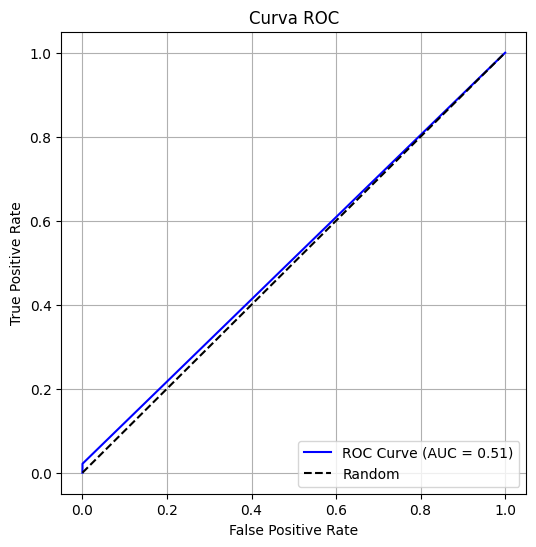

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
auc = roc_auc_score(y_val, y_pred_prob)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
test_red.head()

In [ ]:
print(test_red.columns)

In [ ]:
print(len(test_red), len(y_test_pred))

In [ ]:
##SUBIDA A KAGGLE
import numpy as np
import pandas as pd

# Tamaño del batch
batch_size = 10000

# Predecir por lotes
y_test_prob = []
for i in range(0, len(test_red), batch_size):
    batch = test_red[i:i + batch_size]
    preds = model1.predict(batch).ravel()
    y_test_prob.extend(preds)

# Convertir a array de NumPy
y_test_prob = np.array(y_test_prob)


# Crear CSV para Kaggle
submission = pd.DataFrame({
    'TransactionID': test_red['TransactionID'],
    'isFraud': y_test_prob
})

submission.to_csv('Modelo1RNA_SMOTE.csv', index=False)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
submission.head()

In [ ]:
from google.colab import files
files.download('Modelo1RNA_SMOTE.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Propuestas  de mejora:

- Función de pérdida: reemplazar binary cross-entropy por Focal Loss (penaliza menos los errores en la clase mayoritaria) (revisar teoria de los apuntes ML y Deep Learning para fundamentar explicacion)

- Umbral adaptativo: evaluar múltiples umbrales (ej. 0.1-0.3) en lugar de 0.5 para priorizar recall.

- Métricas: monitorear AUC-ROC y Recall (no accuracy) durante el entrenamiento. (esto también se dice en el estado del arte)

- Arquitectura: añadir BatchNormalization y Dropout para evitar overfitting.

## Modelo 2 RNA

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)

        # Focal Loss
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = K.pow((1 - p_t), gamma)

        loss = -alpha_factor * modulating_factor * K.log(p_t)
        return K.mean(loss)
    return focal_loss_fn

In [ ]:
from tensorflow.keras.layers import Dropout, BatchNormalization
# 4. Definir la red con Focal Loss
model2 = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_res.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])


# Compilar con Focal Loss (se puede ajustar gamma y alpha)
model2.compile(
    optimizer='adam',
    loss=focal_loss(gamma=2.0, alpha=0.25),  # Usando Focal Loss calculada
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

# 5. Entrenamiento
history = model2.fit(
    X_train_res, y_train_res,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=512,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True, monitor='val_recall', mode='max')],
    verbose=2
)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


91/91 - 3s - 37ms/step - accuracy: 0.4999 - loss: 0.1470 - precision: 0.4999 - recall: 0.4047 - val_accuracy: 0.9610 - val_loss: 0.0198 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
91/91 - 0s - 5ms/step - accuracy: 0.4985 - loss: 0.1010 - precision: 0.4964 - recall: 0.2073 - val_accuracy: 0.9610 - val_loss: 0.0671 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
91/91 - 0s - 5ms/step - accuracy: 0.4976 - loss: 0.0888 - precision: 0.4917 - recall: 0.1392 - val_accuracy: 0.9610 - val_loss: 0.0176 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
91/91 - 1s - 7ms/step - accuracy: 0.4974 - loss: 0.0823 - precision: 0.4869 - recall: 0.0972 - val_accuracy: 0.9610 - val_loss: 0.0272 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Predicciones (probabilidades)
y_pred_prob = model2.predict(X_val)

# Evaluación con diferentes umbrales
for threshold in [0.1, 0.2, 0.3, 0.5]:
    y_pred = (y_pred_prob >= threshold).astype(int)
    print(f"\nEvaluación con umbral {threshold:.1f}:")
    print(classification_report(y_val, y_pred))
    print("Matriz de Confusión:")
    print(confusion_matrix(y_val, y_pred))

# Métrica AUC-ROC (importante para clases desbalanceadas)
print("\nAUC-ROC:", roc_auc_score(y_val, y_pred_prob))

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Evaluación con umbral 0.1:
              precision    recall  f1-score   support

           0       0.96      0.85      0.90      5766
           1       0.03      0.10      0.04       234

    accuracy                           0.82      6000
   macro avg       0.49      0.48      0.47      6000
weighted avg       0.92      0.82      0.87      6000

Matriz de Confusión:
[[4892  874]
 [ 210   24]]

Evaluación con umbral 0.2:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5766
           1       0.00      0.00      0.00       234

    accuracy                           0.96      6000
   macro avg       0.48      0.50      0.49      6000
weighted avg       0.92      0.96      0.94      6000

Matriz de Confusión:
[[5766    0]
 [ 234    0]]

Evaluación con umbral 0.3:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5766
           1    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

- Umbral 0.1: el modelo marca TODO como fraude (recall=100% para fraude, pero precision=0% para no fraude). Inútil en la práctica (0% de aciertos en no fraude)

- Umbral 0.2: mejor equilibrio; Detecta el 83% de fraudes (174/210), pero con muchos falsos positivos (4612 no-fraudes marcados como fraude). Precision muy baja (4% en fraude)

- Umbral 0.3: 48% de fraudes detectados (101/210). Menos falsos positivos (2769). Precision sigue baja (4%)

- Umbral 0.5: Ignora completamente la clase de fraude

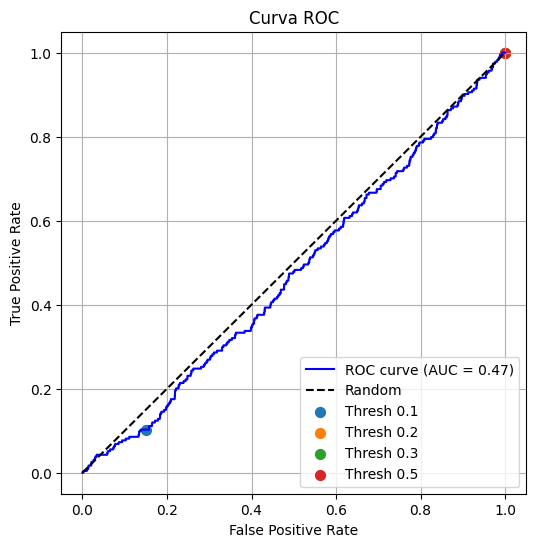

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
auc = roc_auc_score(y_val, y_pred_prob)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random')

# Marcar los puntos para cada umbral que analizaste
for thresh in [0.1, 0.2, 0.3, 0.5]:
    y_temp = (y_pred_prob >= thresh).astype(int)
    fpr_t, tpr_t, _ = roc_curve(y_val, y_temp)
    plt.scatter(fpr_t[1], tpr_t[1], label=f'Thresh {thresh:.1f}', s=50)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd

# Tamaño del batch
batch_size = 10000

# Predecir probabilidades por lotes (solo una vez)
y_test_prob = []
for i in range(0, len(test_red), batch_size):
    batch = test_red[i:i + batch_size]
    preds = model2.predict(batch).ravel()
    y_test_prob.extend(preds)

y_test_prob = np.array(y_test_prob)

# Para cada umbral, generar predicciones y CSV
for threshold in [0.1, 0.2, 0.3, 0.5]:

    submission = pd.DataFrame({
        'TransactionID': test_red['TransactionID'],
        'isFraud': y_test_prob
    })

    filename = f'Modelo2RNA_SMOTE_umbral_{int(threshold*100)}.csv'
    submission.to_csv(filename, index=False)
    print(f"Guardado: {filename}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━

In [ ]:
from google.colab import files
files.download('Modelo2RNA_SMOTE_umbral_10.csv')
files.download('Modelo2RNA_SMOTE_umbral_20.csv')
files.download('Modelo2RNA_SMOTE_umbral_30.csv')
files.download('Modelo2RNA_SMOTE_umbral_50.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Investigando sobre modelos de redes neuronales aplicados a la detección de fraude vi que los que ofrecen mejores resultados son TabNet

## Modelo 3 TabNet

In [ ]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.8 MB/s eta 0:00:00


In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier
import numpy as np

# Prepara tus datos (X_train_res, y_train_res ya balanceados con SMOTE)
X_train_np = X_train_res.values
y_train_np = y_train_res.values

X_val_np = X_val.values
y_val_np = y_val.values

# Inicializa y entrena TabNet
tabnet = TabNetClassifier(
    n_d=16, n_a=16, n_steps=5,
    gamma=1.5, n_independent=2,
    n_shared=2, seed=42,
    verbose=10
)

tabnet.fit(
    X_train_np, y_train_np,
    eval_set=[(X_val_np, y_val_np)],
    max_epochs=100,
    patience=20,
    batch_size=1024,
    virtual_batch_size=128
)

# Predicciones y métricas
y_pred = tabnet.predict(X_val_np)
from sklearn.metrics import classification_report
print(classification_report(y_val_np, y_pred))

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68944 | val_0_auc: 0.61021 |  0:00:07s
epoch 10 | loss: 0.3694  | val_0_auc: 0.71667 |  0:01:17s
epoch 20 | loss: 0.35134 | val_0_auc: 0.56799 |  0:02:26s
epoch 30 | loss: 0.31308 | val_0_auc: 0.54601 |  0:03:36s
epoch 40 | loss: 0.25946 | val_0_auc: 0.75941 |  0:04:45s
epoch 50 | loss: 0.21925 | val_0_auc: 0.62415 |  0:05:53s
epoch 60 | loss: 0.21017 | val_0_auc: 0.60245 |  0:07:03s
epoch 70 | loss: 0.19987 | val_0_auc: 0.72756 |  0:08:11s

Early stopping occurred at epoch 73 with best_epoch = 53 and best_val_0_auc = 0.77791


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5766
           1       0.28      0.26      0.27       234

    accuracy                           0.95      6000
   macro avg       0.63      0.61      0.62      6000
weighted avg       0.94      0.95      0.94      6000



In [ ]:
# Matriz de confusión
print("Matriz de Confusión:")
print(confusion_matrix(y_val_np, y_pred))

Matriz de Confusión:
[[5613  153]
 [ 174   60]]


Los resultados del modelo muestran una mejora notable en la capacidad para detectar la clase minoritaria (1). Aunque la precisión para la clase 1 sigue siendo baja (0.10), el recall ha aumentado significativamente a 0.64, lo que indica que el modelo ahora identifica correctamente el 64% de las instancias positivas. Sin embargo, este avance viene acompañado de un aumento en los falsos positivos, lo que explica la baja precisión y la caída de la precisión general (accuracy) al 78%. La macro media del F1-score es 0.52, reflejando el desequilibrio entre clases, pero es un paso adelante respecto al modelo anterior, que apenas detectaba la clase 1. En resumen, el modelo ha ganado sensibilidad para detectar fraudes, aunque aún necesita mejoras para reducir las falsas alarmas y lograr un mejor equilibrio entre precisión y recall.

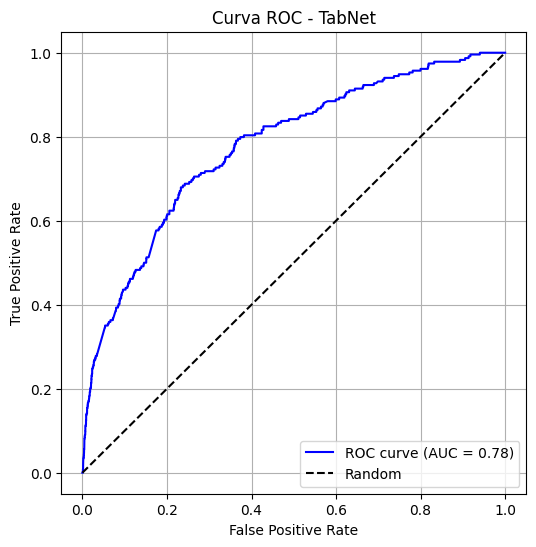

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Obtener probabilidades de clase positiva (1)
y_pred_prob = tabnet.predict_proba(X_val_np)[:, 1]

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_val_np, y_pred_prob)
auc_score = roc_auc_score(y_val_np, y_pred_prob)

# Graficar
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - TabNet')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd

test_np = test_red.values

In [ ]:
hay_nulos = np.isnan(test_np).any()

print("¿Hay nulos en test_np?", hay_nulos)

In [ ]:
# TabNet predicción completa
y_test_prob = tabnet.predict_proba(test_np)[:, 1]  # Probabilidad de clase 1

In [ ]:
# Aplica umbral
#y_test_pred = (y_test_prob >= 0.5).astype(int)

In [ ]:
# Genera CSV para Kaggle
submission = pd.DataFrame({
    'TransactionID': test_red['TransactionID'].values,
    'isFraud': y_test_prob
})

submission.to_csv('Modelo3TabNet.csv', index=False)
print(" CSV guardado como Modelo3TabNet.csv")

 CSV guardado como Modelo3TabNet.csv


In [ ]:
from google.colab import files
files.download('Modelo3TabNet.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Modelo 4 SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler


svm_smote = SVC(kernel='rbf', probability=True, random_state=42)
svm_smote.fit(X_train_res, y_train_res)

# 5. Evaluar
y_pred = svm_smote.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.42      0.58      5766
           1       0.04      0.62      0.08       234

    accuracy                           0.43      6000
   macro avg       0.50      0.52      0.33      6000
weighted avg       0.93      0.43      0.56      6000



In [ ]:
# Matriz de confusión
print("Matriz de Confusión:")
print(confusion_matrix(y_val, y_pred))

Matriz de Confusión:
[[2411 3355]
 [  88  146]]


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

disp.plot(cmap='Blues')

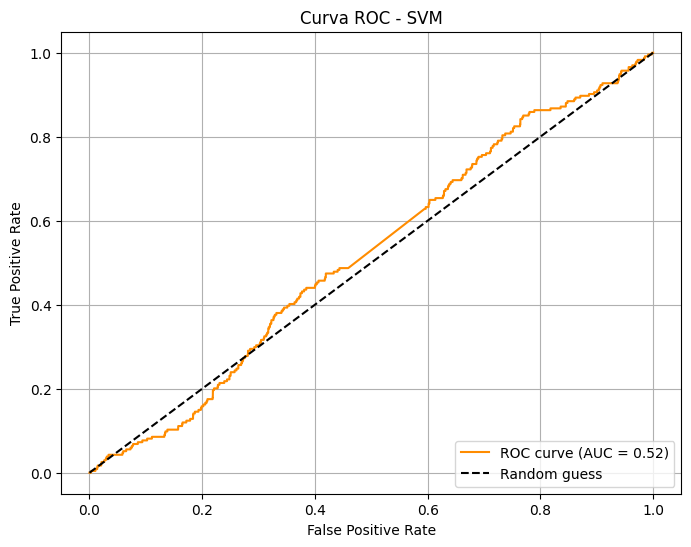

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Obtener probabilidades para clase positiva
y_pred_prob = svm_smote.predict_proba(X_val)[:, 1]

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Dibujar la curva
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - SVM')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


COMENTAR

In [ ]:
##SUBIDA A KAGGLE
import numpy as np
import pandas as pd

# Tamaño del batch
batch_size = 10000

# Predecir por lotes
y_test_prob = []
for i in range(0, len(test_red), batch_size):
    batch = test_red[i:i + batch_size]
    preds = svm_smote.predict(batch).ravel()
    y_test_prob.extend(preds)

# Convertir a array de NumPy
y_test_prob = np.array(y_test_prob)

# Aplicar umbral
#y_test_pred = (y_test_prob >= 0.5).astype(int)

# Crear CSV para Kaggle
submission = pd.DataFrame({
    'TransactionID': test_red['TransactionID'],
    'isFraud': y_test_prob
})

submission.to_csv('ModeloSVM_SMOTE.csv', index=False)


In [ ]:
from google.colab import files
files.download('ModeloSVM_SMOTE.csv')

##Modelo 5 XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
# 4. Entrenar modelo
xgb_smote = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_smote.fit(X_train_res, y_train_res)

# 5. Evaluar
y_pred = xgb_smote.predict(X_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:53:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5766
           1       0.76      0.35      0.48       234

    accuracy                           0.97      6000
   macro avg       0.87      0.68      0.73      6000
weighted avg       0.97      0.97      0.97      6000

[[5740   26]
 [ 151   83]]


El modelo XGBoost con SMOTE ha logrado un alto rendimiento general, con una accuracy del 97%. Para la clase mayoritaria (no fraude), el modelo obtiene un excelente desempeño (precision y recall cercanos a 1). En cuanto a la clase minoritaria (fraude), se observa una precision del 79%, lo que significa que cuando predice fraude, suele acertar. Sin embargo, su recall es del 38%, lo que indica que detecta un poco más de un tercio de los fraudes reales. Aunque esto supone una mejora respecto a modelos anteriores, aún hay margen para mejorar la capacidad de detección de todos los fraudes reales. La matriz de confusión muestra 80 fraudes correctamente identificados, pero 130 que el modelo no detectó. En resumen, es un modelo muy prometedor, especialmente si se prioriza evitar falsos positivos, aunque podría beneficiarse de ajustes para mejorar el recall de la clase minoritaria.

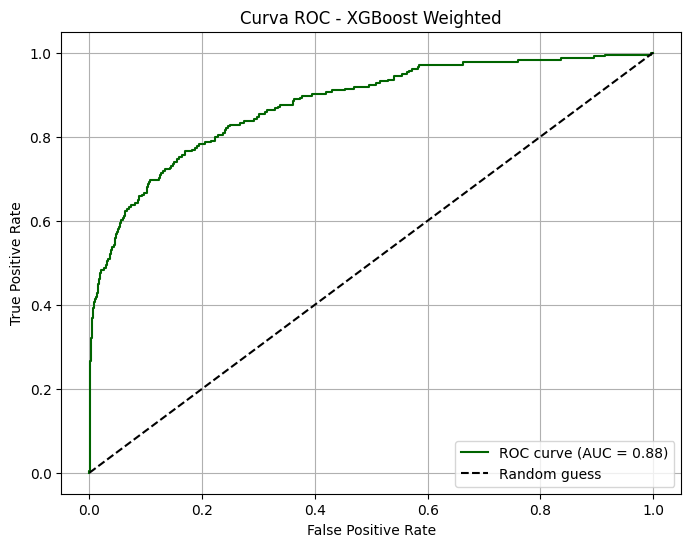

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Obtener las probabilidades para la clase 1
y_pred_prob = xgb_smote.predict_proba(X_val)[:, 1]

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkgreen')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - XGBoost Weighted')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
##SUBIDA A KAGGLE
import numpy as np
import pandas as pd

# Tamaño del batch
batch_size = 10000

# Predecir por lotes
y_test_prob = []
for i in range(0, len(test_red), batch_size):
    batch = test_red[i:i + batch_size]
    preds = xgb_smote.predict(batch).ravel()
    y_test_prob.extend(preds)

# Convertir a array de NumPy
y_test_prob = np.array(y_test_prob)

# Aplicar umbral
#y_test_pred = (y_test_prob >= 0.5).astype(int)

# Crear CSV para Kaggle
submission = pd.DataFrame({
    'TransactionID': test_red['TransactionID'],
    'isFraud': y_test_prob
})

submission.to_csv('ModeloXGBoost_SMOTE.csv', index=False)

In [ ]:
from google.colab import files
files.download('ModeloXGBoost_SMOTE.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Modelo 6 LightGBM

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# Entrenar LightGBM (hiperparámetros básicos)
lgbm_smote = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    random_state=42
)
lgbm_smote.fit(X_train_res, y_train_res)

# Evaluar
y_pred = lgbm_smote.predict(X_val)
print(classification_report(y_val, y_pred))


[LightGBM] [Info] Number of positive: 23185, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27638
[LightGBM] [Info] Number of data points in the train set: 46370, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5766
           1       0.77      0.32      0.45       234

    accuracy                           0.97      6000
   macro avg       0.87      0.66      0.72      6000
weighted avg       0.97      0.97      0.96      6000



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_val, y_pred))

[[5744   22]
 [ 159   75]]


Los resultados del modelo LightGBM con SMOTE son bastante sólidos a nivel global, con una accuracy del 97% y una excelente performance para la clase mayoritaria (0), alcanzando un recall del 100% y una precisión del 98%. Para la clase minoritaria (1, fraude), el modelo logra una precisión del 80%, lo cual es muy bueno: cuando predice fraude, acierta 8 de cada 10 veces. Sin embargo, el recall es del 37%, lo que indica que el modelo solo detecta 77 de los 210 fraudes reales, dejando 133 sin identificar. En conjunto, el F1-score para la clase 1 es de 0.50, mostrando un compromiso aceptable entre precisión y recall, aunque aún con margen de mejora. Este comportamiento es típico cuando se entrena con SMOTE: mejora la detección de fraudes sin aumentar demasiado los falsos positivos, pero puede seguir costando identificar todos los positivos reales. La matriz de confusión confirma este patrón.

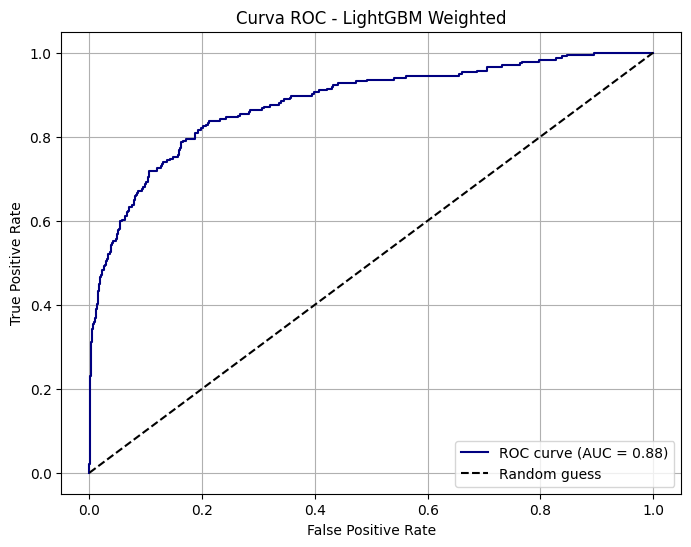

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Probabilidades para la clase 1 (fraude)
y_pred_prob = lgbm_smote.predict_proba(X_val)[:, 1]

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Graficar
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='navy')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - LightGBM Weighted')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
##SUBIDA A KAGGLE
import numpy as np
import pandas as pd

# Tamaño del batch
batch_size = 10000

# Predecir por lotes
y_test_prob = []
for i in range(0, len(test_red), batch_size):
    batch = test_red[i:i + batch_size]
    preds = lgbm_smote.predict(batch).ravel()
    y_test_prob.extend(preds)

# Convertir a array de NumPy
y_test_prob = np.array(y_test_prob)

# Aplicar umbral
#y_test_pred = (y_test_prob >= 0.5).astype(int)

# Crear CSV para Kaggle
submission = pd.DataFrame({
    'TransactionID': test_red['TransactionID'],
    'isFraud': y_test_prob
})

submission.to_csv('ModeloLightGBM_SMOTE.csv', index=False)


In [ ]:
from google.colab import files
files.download('ModeloLightGBM_SMOTE.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Modelo 7 OLightGBM -  SIN SMOTE

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 19.9 MB/s eta 0:00:00


In [ ]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score


def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 15, 128),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'scale_pos_weight': len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  # class weight
        'random_state': 42,
        'n_jobs': -1
    }

    model7 = LGBMClassifier(**params)
    model7.fit(X_train, y_train)
    y_pred = model7.predict(X_val)
    return f1_score(y_val, y_pred)

# Ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Ver mejores parámetros
print("Mejores parámetros:")
print(study.best_params)

# Entrenar modelo final con los mejores parámetros
best_model = LGBMClassifier(**study.best_params)
best_model.fit(X_train, y_train)


[I 2025-08-24 11:00:48,162] A new study created in memory with name: no-name-21dc24ed-3268-41d1-9353-c53bb845d03b
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13714
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 110
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:00:57,981] Trial 0 finished with value: 0.5043478260869565 and parameters: {'n_estimators': 459, 'learning_rate': 0.1385831087499935, 'num_leaves': 60, 'max_depth': 8, 'min_child_samples': 57, 'subsample': 0.9240123916784051, 'colsample_bytree': 0.8792671896112628}. Best is trial 0 with value: 0.5043478260869565.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:01:00,669] Trial 1 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 358, 'learning_rate': 0.036444787753103725, 'num_leaves': 110, 'max_depth': 4, 'min_child_samples': 62, 'subsample': 0.8030722316334635, 'colsample_bytree': 0.6529936086997398}. Best is trial 0 with value: 0.5043478260869565.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13736
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:01:02,144] Trial 2 finished with value: 0.3114256825075834 and parameters: {'n_estimators': 129, 'learning_rate': 0.023490405231061575, 'num_leaves': 86, 'max_depth': 5, 'min_child_samples': 31, 'subsample': 0.7353380847919602, 'colsample_bytree': 0.6973331627251955}. Best is trial 0 with value: 0.5043478260869565.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13722
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:01:05,311] Trial 3 finished with value: 0.48072562358276644 and parameters: {'n_estimators': 360, 'learning_rate': 0.1336936492719484, 'num_leaves': 76, 'max_depth': 5, 'min_child_samples': 48, 'subsample': 0.9893226402016163, 'colsample_bytree': 0.9705327706182116}. Best is trial 0 with value: 0.5043478260869565.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13736
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:01:09,973] Trial 4 finished with value: 0.3555045871559633 and parameters: {'n_estimators': 112, 'learning_rate': 0.0532972500847766, 'num_leaves': 27, 'max_depth': 6, 'min_child_samples': 27, 'subsample': 0.9089679019369862, 'colsample_bytree': 0.6075731443372515}. Best is trial 0 with value: 0.5043478260869565.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13742
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:01:12,462] Trial 5 finished with value: 0.43912175648702595 and parameters: {'n_estimators': 237, 'learning_rate': 0.07330890954759475, 'num_leaves': 97, 'max_depth': 6, 'min_child_samples': 25, 'subsample': 0.9096451525522795, 'colsample_bytree': 0.6856401512537369}. Best is trial 0 with value: 0.5043478260869565.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13742
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:01:14,305] Trial 6 finished with value: 0.3150259067357513 and parameters: {'n_estimators': 297, 'learning_rate': 0.09127062785831443, 'num_leaves': 81, 'max_depth': 3, 'min_child_samples': 21, 'subsample': 0.8230268629591956, 'colsample_bytree': 0.8048277910397356}. Best is trial 0 with value: 0.5043478260869565.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13722
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:01:19,176] Trial 7 finished with value: 0.5126760563380282 and parameters: {'n_estimators': 300, 'learning_rate': 0.08748676116160364, 'num_leaves': 64, 'max_depth': 11, 'min_child_samples': 43, 'subsample': 0.9510023824034933, 'colsample_bytree': 0.7167866869937705}. Best is trial 7 with value: 0.5126760563380282.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:01:32,286] Trial 8 finished with value: 0.5132275132275133 and parameters: {'n_estimators': 461, 'learning_rate': 0.028589696468206832, 'num_leaves': 102, 'max_depth': 12, 'min_child_samples': 72, 'subsample': 0.7175056040487584, 'colsample_bytree': 0.8548765827735099}. Best is trial 8 with value: 0.5132275132275133.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:01:41,750] Trial 9 finished with value: 0.5286103542234333 and parameters: {'n_estimators': 495, 'learning_rate': 0.07421836697658023, 'num_leaves': 43, 'max_depth': 12, 'min_child_samples': 92, 'subsample': 0.9332331285581239, 'colsample_bytree': 0.6901758073236715}. Best is trial 9 with value: 0.5286103542234333.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073


[I 2025-08-24 11:01:48,506] Trial 10 finished with value: 0.3113207547169811 and parameters: {'n_estimators': 496, 'learning_rate': 0.007779292855147674, 'num_leaves': 21, 'max_depth': 9, 'min_child_samples': 99, 'subsample': 0.6090048514800481, 'colsample_bytree': 0.7652780498626014}. Best is trial 9 with value: 0.5286103542234333.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.272100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:01:57,432] Trial 11 finished with value: 0.43782837127845886 and parameters: {'n_estimators': 430, 'learning_rate': 0.016870517131603632, 'num_leaves': 44, 'max_depth': 12, 'min_child_samples': 84, 'subsample': 0.7023300489453297, 'colsample_bytree': 0.8607100625647295}. Best is trial 9 with value: 0.5286103542234333.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:02:10,809] Trial 12 finished with value: 0.48140900195694714 and parameters: {'n_estimators': 431, 'learning_rate': 0.012385026592782298, 'num_leaves': 126, 'max_depth': 10, 'min_child_samples': 76, 'subsample': 0.7100182182911496, 'colsample_bytree': 0.940071721354479}. Best is trial 9 with value: 0.5286103542234333.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:02:20,855] Trial 13 finished with value: 0.5349397590361445 and parameters: {'n_estimators': 497, 'learning_rate': 0.03779928989751892, 'num_leaves': 44, 'max_depth': 12, 'min_child_samples': 100, 'subsample': 0.8557512872639309, 'colsample_bytree': 0.7822769330484604}. Best is trial 13 with value: 0.5349397590361445.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:02:25,779] Trial 14 finished with value: 0.5106382978723404 and parameters: {'n_estimators': 377, 'learning_rate': 0.0498091970177458, 'num_leaves': 43, 'max_depth': 10, 'min_child_samples': 96, 'subsample': 0.8437100483870932, 'colsample_bytree': 0.7633716977678648}. Best is trial 13 with value: 0.5349397590361445.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:02:35,680] Trial 15 finished with value: 0.4911242603550296 and parameters: {'n_estimators': 494, 'learning_rate': 0.18161161442883517, 'num_leaves': 45, 'max_depth': 12, 'min_child_samples': 86, 'subsample': 0.8742701574336413, 'colsample_bytree': 0.754521346327406}. Best is trial 13 with value: 0.5349397590361445.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:02:38,504] Trial 16 finished with value: 0.40253565768621236 and parameters: {'n_estimators': 212, 'learning_rate': 0.04462908000895755, 'num_leaves': 32, 'max_depth': 10, 'min_child_samples': 89, 'subsample': 0.9983148948465965, 'colsample_bytree': 0.6291288250865243}. Best is trial 13 with value: 0.5349397590361445.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:02:48,273] Trial 17 finished with value: 0.4444444444444444 and parameters: {'n_estimators': 396, 'learning_rate': 0.018228632292956896, 'num_leaves': 55, 'max_depth': 8, 'min_child_samples': 69, 'subsample': 0.7694425546503557, 'colsample_bytree': 0.7995846897615225}. Best is trial 13 with value: 0.5349397590361445.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:02:52,782] Trial 18 finished with value: 0.5072463768115942 and parameters: {'n_estimators': 415, 'learning_rate': 0.07062460339953089, 'num_leaves': 33, 'max_depth': 11, 'min_child_samples': 100, 'subsample': 0.8530868862401375, 'colsample_bytree': 0.6641447176852043}. Best is trial 13 with value: 0.5349397590361445.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073


[I 2025-08-24 11:02:59,439] Trial 19 finished with value: 0.312015503875969 and parameters: {'n_estimators': 344, 'learning_rate': 0.006111310499990652, 'num_leaves': 17, 'max_depth': 11, 'min_child_samples': 79, 'subsample': 0.9557598823047413, 'colsample_bytree': 0.7158689374362994}. Best is trial 13 with value: 0.5349397590361445.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13751
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073


[I 2025-08-24 11:03:07,193] Trial 20 finished with value: 0.4271523178807947 and parameters: {'n_estimators': 466, 'learning_rate': 0.010960991247384774, 'num_leaves': 53, 'max_depth': 9, 'min_child_samples': 11, 'subsample': 0.8788374559101602, 'colsample_bytree': 0.8016179331433505}. Best is trial 13 with value: 0.5349397590361445.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:03:20,383] Trial 21 finished with value: 0.5117493472584856 and parameters: {'n_estimators': 462, 'learning_rate': 0.027008387950518638, 'num_leaves': 101, 'max_depth': 12, 'min_child_samples': 71, 'subsample': 0.6405263808524599, 'colsample_bytree': 0.8673333077698427}. Best is trial 13 with value: 0.5349397590361445.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:03:32,791] Trial 22 finished with value: 0.5226130653266332 and parameters: {'n_estimators': 499, 'learning_rate': 0.032633711907355124, 'num_leaves': 67, 'max_depth': 12, 'min_child_samples': 91, 'subsample': 0.7842905268886555, 'colsample_bytree': 0.9001306819281943}. Best is trial 13 with value: 0.5349397590361445.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:03:44,746] Trial 23 finished with value: 0.5279187817258884 and parameters: {'n_estimators': 491, 'learning_rate': 0.035738633963593516, 'num_leaves': 69, 'max_depth': 11, 'min_child_samples': 94, 'subsample': 0.7658278209643471, 'colsample_bytree': 0.9020275473457505}. Best is trial 13 with value: 0.5349397590361445.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:03:54,202] Trial 24 finished with value: 0.5091743119266054 and parameters: {'n_estimators': 431, 'learning_rate': 0.04187609730892784, 'num_leaves': 38, 'max_depth': 11, 'min_child_samples': 92, 'subsample': 0.6636461619604515, 'colsample_bytree': 0.9916400308658087}. Best is trial 13 with value: 0.5349397590361445.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:04:00,159] Trial 25 finished with value: 0.5 and parameters: {'n_estimators': 400, 'learning_rate': 0.06472647665837875, 'num_leaves': 51, 'max_depth': 9, 'min_child_samples': 83, 'subsample': 0.7595171952539718, 'colsample_bytree': 0.9170811180024665}. Best is trial 13 with value: 0.5349397590361445.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:04:09,079] Trial 26 finished with value: 0.4675834970530452 and parameters: {'n_estimators': 331, 'learning_rate': 0.02092633154102144, 'num_leaves': 73, 'max_depth': 10, 'min_child_samples': 94, 'subsample': 0.8760277332550183, 'colsample_bytree': 0.8212096354813477}. Best is trial 13 with value: 0.5349397590361445.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:04:13,454] Trial 27 finished with value: 0.5359116022099447 and parameters: {'n_estimators': 246, 'learning_rate': 0.10174958645207109, 'num_leaves': 90, 'max_depth': 11, 'min_child_samples': 80, 'subsample': 0.827930846851449, 'colsample_bytree': 0.7385130886880085}. Best is trial 27 with value: 0.5359116022099447.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:04:21,351] Trial 28 finished with value: 0.523943661971831 and parameters: {'n_estimators': 252, 'learning_rate': 0.11307328553784762, 'num_leaves': 87, 'max_depth': 12, 'min_child_samples': 79, 'subsample': 0.8362193345397427, 'colsample_bytree': 0.7493981170198915}. Best is trial 27 with value: 0.5359116022099447.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:04:23,814] Trial 29 finished with value: 0.4789473684210526 and parameters: {'n_estimators': 174, 'learning_rate': 0.16867176882042836, 'num_leaves': 61, 'max_depth': 8, 'min_child_samples': 61, 'subsample': 0.9351541860691494, 'colsample_bytree': 0.7345081532031617}. Best is trial 27 with value: 0.5359116022099447.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:04:26,617] Trial 30 finished with value: 0.4930232558139535 and parameters: {'n_estimators': 217, 'learning_rate': 0.11347747884328786, 'num_leaves': 120, 'max_depth': 7, 'min_child_samples': 66, 'subsample': 0.8102011981581418, 'colsample_bytree': 0.6634621094090419}. Best is trial 27 with value: 0.5359116022099447.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:04:39,111] Trial 31 finished with value: 0.5150684931506849 and parameters: {'n_estimators': 466, 'learning_rate': 0.05922800904149291, 'num_leaves': 91, 'max_depth': 11, 'min_child_samples': 100, 'subsample': 0.8952060888575762, 'colsample_bytree': 0.8291306325008052}. Best is trial 27 with value: 0.5359116022099447.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:04:46,976] Trial 32 finished with value: 0.5027322404371585 and parameters: {'n_estimators': 285, 'learning_rate': 0.08847628425160667, 'num_leaves': 68, 'max_depth': 11, 'min_child_samples': 88, 'subsample': 0.7965853170537847, 'colsample_bytree': 0.7806758791123797}. Best is trial 27 with value: 0.5359116022099447.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:04:51,122] Trial 33 finished with value: 0.4827586206896552 and parameters: {'n_estimators': 261, 'learning_rate': 0.036700215252237114, 'num_leaves': 77, 'max_depth': 10, 'min_child_samples': 94, 'subsample': 0.7501163020369991, 'colsample_bytree': 0.6921657411572923}. Best is trial 27 with value: 0.5359116022099447.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13722
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:04:54,133] Trial 34 finished with value: 0.5054945054945055 and parameters: {'n_estimators': 177, 'learning_rate': 0.13963793539379515, 'num_leaves': 58, 'max_depth': 11, 'min_child_samples': 53, 'subsample': 0.8519856137232859, 'colsample_bytree': 0.7314825366232931}. Best is trial 27 with value: 0.5359116022099447.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:05:07,265] Trial 35 finished with value: 0.519774011299435 and parameters: {'n_estimators': 487, 'learning_rate': 0.054127130904116263, 'num_leaves': 110, 'max_depth': 12, 'min_child_samples': 82, 'subsample': 0.9774516245853903, 'colsample_bytree': 0.63402472430236}. Best is trial 27 with value: 0.5359116022099447.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-24 11:05:15,111] Trial 36 finished with value: 0.45471349353049906 and parameters: {'n_estimators': 435, 'learning_rate': 0.036633162820300186, 'num_leaves': 26, 'max_depth': 9, 'min_child_samples': 76, 'subsample': 0.7894860100741241, 'colsample_bytree': 0.8362619421153381}. Best is trial 27 with value: 0.5359116022099447.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13729
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 112
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:05:17,333] Trial 37 finished with value: 0.47345132743362833 and parameters: {'n_estimators': 164, 'learning_rate': 0.11018318848189179, 'num_leaves': 82, 'max_depth': 7, 'min_child_samples': 41, 'subsample': 0.8222873614319622, 'colsample_bytree': 0.7082753483770022}. Best is trial 27 with value: 0.5359116022099447.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:05:20,197] Trial 38 finished with value: 0.39509954058192953 and parameters: {'n_estimators': 447, 'learning_rate': 0.07959732118759573, 'num_leaves': 49, 'max_depth': 4, 'min_child_samples': 88, 'subsample': 0.9268141453302952, 'colsample_bytree': 0.6822897488237857}. Best is trial 27 with value: 0.5359116022099447.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:05:29,196] Trial 39 finished with value: 0.5247524752475248 and parameters: {'n_estimators': 319, 'learning_rate': 0.04395869874674777, 'num_leaves': 95, 'max_depth': 11, 'min_child_samples': 96, 'subsample': 0.7352336409294528, 'colsample_bytree': 0.7855002338412829}. Best is trial 27 with value: 0.5359116022099447.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13714
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 110
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-24 11:05:36,275] Trial 40 finished with value: 0.46938775510204084 and parameters: {'n_estimators': 482, 'learning_rate': 0.026556653730528554, 'num_leaves': 37, 'max_depth': 12, 'min_child_samples': 57, 'subsample': 0.9594881501511122, 'colsample_bytree': 0.8840400795114278}. Best is trial 27 with value: 0.5359116022099447.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:05:45,535] Trial 41 finished with value: 0.5286783042394015 and parameters: {'n_estimators': 317, 'learning_rate': 0.04292457745784235, 'num_leaves': 93, 'max_depth': 11, 'min_child_samples': 96, 'subsample': 0.7277675713685351, 'colsample_bytree': 0.7354977884384305}. Best is trial 27 with value: 0.5359116022099447.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:05:48,307] Trial 42 finished with value: 0.47558386411889597 and parameters: {'n_estimators': 147, 'learning_rate': 0.06256764262816526, 'num_leaves': 108, 'max_depth': 10, 'min_child_samples': 95, 'subsample': 0.69546859653454, 'colsample_bytree': 0.7264098891428786}. Best is trial 27 with value: 0.5359116022099447.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:05:58,226] Trial 43 finished with value: 0.5173210161662818 and parameters: {'n_estimators': 370, 'learning_rate': 0.02418018001619846, 'num_leaves': 89, 'max_depth': 11, 'min_child_samples': 91, 'subsample': 0.7353321644551118, 'colsample_bytree': 0.7724793516353068}. Best is trial 27 with value: 0.5359116022099447.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:06:03,273] Trial 44 finished with value: 0.498960498960499 and parameters: {'n_estimators': 229, 'learning_rate': 0.03195244385365705, 'num_leaves': 79, 'max_depth': 12, 'min_child_samples': 99, 'subsample': 0.7768165820079163, 'colsample_bytree': 0.9552342388707443}. Best is trial 27 with value: 0.5359116022099447.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:06:11,325] Trial 45 finished with value: 0.5257731958762887 and parameters: {'n_estimators': 273, 'learning_rate': 0.05199506978475394, 'num_leaves': 98, 'max_depth': 11, 'min_child_samples': 86, 'subsample': 0.9031181058159259, 'colsample_bytree': 0.7505367604994293}. Best is trial 27 with value: 0.5359116022099447.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:06:15,179] Trial 46 finished with value: 0.5210526315789473 and parameters: {'n_estimators': 196, 'learning_rate': 0.09628648136285135, 'num_leaves': 109, 'max_depth': 10, 'min_child_samples': 81, 'subsample': 0.6770142951277698, 'colsample_bytree': 0.6002453550065184}. Best is trial 27 with value: 0.5359116022099447.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:06:26,195] Trial 47 finished with value: 0.5250737463126843 and parameters: {'n_estimators': 477, 'learning_rate': 0.1351977937761646, 'num_leaves': 83, 'max_depth': 12, 'min_child_samples': 96, 'subsample': 0.8156434661767787, 'colsample_bytree': 0.6787055329880886}. Best is trial 27 with value: 0.5359116022099447.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:06:34,679] Trial 48 finished with value: 0.523943661971831 and parameters: {'n_estimators': 309, 'learning_rate': 0.0766932050397214, 'num_leaves': 71, 'max_depth': 12, 'min_child_samples': 77, 'subsample': 0.7458714954155203, 'colsample_bytree': 0.7408245000935202}. Best is trial 27 with value: 0.5359116022099447.
/tmp/ipython-input-3635955088.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:06:35,605] Trial 49 finished with value: 0.2540381791483113 and parameters: {'n_estimators': 102, 'learning_rate': 0.03952753959016996, 'num_leaves': 115, 'max_depth': 3, 'min_child_samples': 84, 'subsample': 0.8603949791287666, 'colsample_bytree': 0.7013969609167169}. Best is trial 27 with value: 0.5359116022099447.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMClassifier(colsample_bytree=0.7385130886880085,
               learning_rate=0.10174958645207109, max_depth=11,
               min_child_samples=80, n_estimators=246, num_leaves=90,
               subsample=0.827930846851449)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      5766
           1       0.84      0.33      0.47       234

    accuracy                           0.97      6000
   macro avg       0.91      0.66      0.73      6000
weighted avg       0.97      0.97      0.97      6000



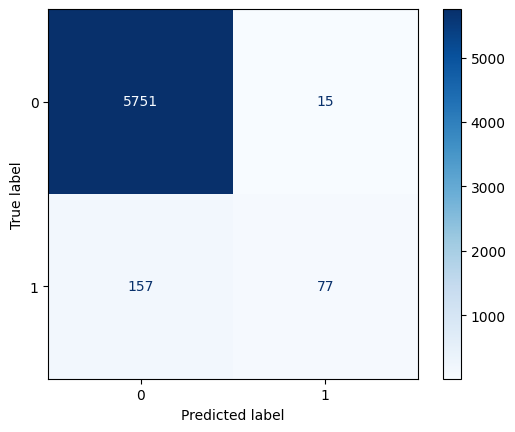

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. Predicciones
y_pred = best_model.predict(X_val)

# 2. Reporte de métricas
print("Classification Report:")
print(classification_report(y_val, y_pred))

# 3. Matriz de confusión
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_val, y_pred))

[[5751   15]
 [ 157   77]]


La accuracy total es del 98%, gracias al excelente desempeño en la clase 0 (no fraude).

Para la clase 1 (fraude), el modelo logra una precisión del 90%, es decir, casi todas las veces que predice fraude, acierta.

Sin embargo, el recall es solo del 33%, lo que significa que solo detecta 70 de los 210 fraudes reales, dejando escapar 140.

El F1-score de la clase 1 es 0.49, reflejando el bajo recall a pesar de la alta precisión.

La matriz de confusión muestra que el modelo es conservador al predecir fraude: prefiere no marcarlo a equivocarse.



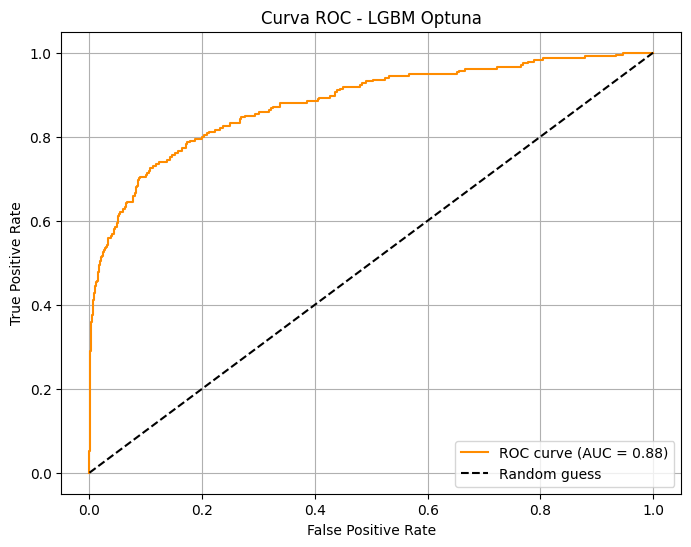

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 1. Probabilidades de clase 1 (fraude)
y_pred_prob = best_model.predict_proba(X_val)[:, 1]

# 2. Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)

# 3. Graficar
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - LGBM Optuna')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
##SUBIDA A KAGGLE
import numpy as np
import pandas as pd

# Tamaño del batch
batch_size = 10000

# Predecir por lotes
y_test_prob = []
for i in range(0, len(test_red), batch_size):
    batch = test_red[i:i + batch_size]
    preds = best_model.predict(batch).ravel()
    y_test_prob.extend(preds)

# Convertir a array de NumPy
y_test_prob = np.array(y_test_prob)

# Aplicar umbral
#y_test_pred = (y_test_prob >= 0.5).astype(int)

# Crear CSV para Kaggle
submission = pd.DataFrame({
    'TransactionID': test_red['TransactionID'],
    'isFraud': y_test_prob
})

submission.to_csv('ModeloOLightGBM_1.csv', index=False)

In [ ]:
from google.colab import files
files.download('ModeloOLightGBM_1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CAMBIAMOS LA METRICA

In [ ]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.metrics import average_precision_score


def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 15, 128),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'scale_pos_weight': len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  # class weight
        'random_state': 42,
        'n_jobs': -1
    }

    model7B = LGBMClassifier(**params)
    model7B.fit(X_train, y_train)
    y_pred = model7B.predict(X_val)
    return average_precision_score(y_val, y_pred)

# Ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Ver mejores parámetros
print("Mejores parámetros:")
print(study.best_params)

# Entrenar modelo final con los mejores parámetros
best_model = LGBMClassifier(**study.best_params)
best_model.fit(X_train, y_train)

[I 2025-08-24 11:10:10,439] A new study created in memory with name: no-name-a0791791-ca3e-46ec-a69a-a375a8df7286
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13729
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 112
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:10:14,403] Trial 0 finished with value: 0.24873573842178492 and parameters: {'n_estimators': 332, 'learning_rate': 0.07353290632728317, 'num_leaves': 104, 'max_depth': 6, 'min_child_samples': 42, 'subsample': 0.8603486789672556, 'colsample_bytree': 0.8527201730546508}. Best is trial 0 with value: 0.24873573842178492.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:10:15,851] Trial 1 finished with value: 0.14562872000823807 and parameters: {'n_estimators': 214, 'learning_rate': 0.1092888643907561, 'num_leaves': 125, 'max_depth': 3, 'min_child_samples': 96, 'subsample': 0.8650701944961032, 'colsample_bytree': 0.8642361479718565}. Best is trial 0 with value: 0.24873573842178492.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13714
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 110
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:10:19,715] Trial 2 finished with value: 0.20171039518087489 and parameters: {'n_estimators': 176, 'learning_rate': 0.010606503578978172, 'num_leaves': 115, 'max_depth': 8, 'min_child_samples': 60, 'subsample': 0.9491495057664692, 'colsample_bytree': 0.642057317395365}. Best is trial 0 with value: 0.24873573842178492.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:10:26,381] Trial 3 finished with value: 0.2538677288191851 and parameters: {'n_estimators': 164, 'learning_rate': 0.005605429753384318, 'num_leaves': 101, 'max_depth': 8, 'min_child_samples': 97, 'subsample': 0.8916365776567047, 'colsample_bytree': 0.8080453541815338}. Best is trial 3 with value: 0.2538677288191851.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13748
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:10:28,816] Trial 4 finished with value: 0.13664102564102565 and parameters: {'n_estimators': 318, 'learning_rate': 0.011931623182792093, 'num_leaves': 77, 'max_depth': 4, 'min_child_samples': 15, 'subsample': 0.818555200766656, 'colsample_bytree': 0.6939782943944114}. Best is trial 3 with value: 0.2538677288191851.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13736
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-24 11:10:40,234] Trial 5 finished with value: 0.23899724379854675 and parameters: {'n_estimators': 374, 'learning_rate': 0.008264922332332631, 'num_leaves': 90, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.8187055647235443, 'colsample_bytree': 0.9435264466825023}. Best is trial 3 with value: 0.2538677288191851.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:10:45,444] Trial 6 finished with value: 0.2773308050297579 and parameters: {'n_estimators': 294, 'learning_rate': 0.04248630810225266, 'num_leaves': 97, 'max_depth': 10, 'min_child_samples': 93, 'subsample': 0.8555668087782278, 'colsample_bytree': 0.8794243790755025}. Best is trial 6 with value: 0.2773308050297579.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13742
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:10:48,838] Trial 7 finished with value: 0.12700080725998364 and parameters: {'n_estimators': 459, 'learning_rate': 0.0074062020000132895, 'num_leaves': 52, 'max_depth': 3, 'min_child_samples': 23, 'subsample': 0.6881448698902675, 'colsample_bytree': 0.8234338510670237}. Best is trial 6 with value: 0.2773308050297579.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.388395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:10:56,142] Trial 8 finished with value: 0.16533339897856028 and parameters: {'n_estimators': 465, 'learning_rate': 0.016967922178913235, 'num_leaves': 20, 'max_depth': 8, 'min_child_samples': 80, 'subsample': 0.7260955842277941, 'colsample_bytree': 0.990143160588752}. Best is trial 6 with value: 0.2773308050297579.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13714
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 110
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:10:57,008] Trial 9 finished with value: 0.1483844557931695 and parameters: {'n_estimators': 106, 'learning_rate': 0.11132164534999178, 'num_leaves': 90, 'max_depth': 3, 'min_child_samples': 60, 'subsample': 0.7886790990815852, 'colsample_bytree': 0.7698387340234225}. Best is trial 6 with value: 0.2773308050297579.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:11:01,446] Trial 10 finished with value: 0.2553870967741936 and parameters: {'n_estimators': 250, 'learning_rate': 0.0385257445501612, 'num_leaves': 51, 'max_depth': 12, 'min_child_samples': 78, 'subsample': 0.6227744475435463, 'colsample_bytree': 0.9178696447747825}. Best is trial 6 with value: 0.2773308050297579.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:11:09,152] Trial 11 finished with value: 0.27360028099754125 and parameters: {'n_estimators': 253, 'learning_rate': 0.04178274917253245, 'num_leaves': 53, 'max_depth': 12, 'min_child_samples': 77, 'subsample': 0.6062843669447144, 'colsample_bytree': 0.9156442962208875}. Best is trial 6 with value: 0.2773308050297579.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:11:13,556] Trial 12 finished with value: 0.264496077996078 and parameters: {'n_estimators': 260, 'learning_rate': 0.0389415012069149, 'num_leaves': 50, 'max_depth': 12, 'min_child_samples': 80, 'subsample': 0.9982976168850126, 'colsample_bytree': 0.8937382668302123}. Best is trial 6 with value: 0.2773308050297579.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:11:22,945] Trial 13 finished with value: 0.2705729613733906 and parameters: {'n_estimators': 395, 'learning_rate': 0.021448017382089464, 'num_leaves': 69, 'max_depth': 10, 'min_child_samples': 70, 'subsample': 0.7200885089355493, 'colsample_bytree': 0.746269776388078}. Best is trial 6 with value: 0.2773308050297579.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:11:26,814] Trial 14 finished with value: 0.26269278252611583 and parameters: {'n_estimators': 276, 'learning_rate': 0.061302996984741634, 'num_leaves': 35, 'max_depth': 10, 'min_child_samples': 90, 'subsample': 0.6436887142773668, 'colsample_bytree': 0.9887147298463135}. Best is trial 6 with value: 0.2773308050297579.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13722
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:11:37,309] Trial 15 finished with value: 0.30773266078184114 and parameters: {'n_estimators': 365, 'learning_rate': 0.05782821896378575, 'num_leaves': 77, 'max_depth': 10, 'min_child_samples': 46, 'subsample': 0.7679215262323453, 'colsample_bytree': 0.939994320753176}. Best is trial 15 with value: 0.30773266078184114.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13729
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 112
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:11:48,789] Trial 16 finished with value: 0.28334817813765184 and parameters: {'n_estimators': 397, 'learning_rate': 0.023334283130363162, 'num_leaves': 78, 'max_depth': 10, 'min_child_samples': 41, 'subsample': 0.766522860716402, 'colsample_bytree': 0.9538472328134473}. Best is trial 15 with value: 0.30773266078184114.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13722
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:12:00,193] Trial 17 finished with value: 0.2837692307692308 and parameters: {'n_estimators': 410, 'learning_rate': 0.022485656793532722, 'num_leaves': 75, 'max_depth': 10, 'min_child_samples': 43, 'subsample': 0.7669925956815993, 'colsample_bytree': 0.9472074754136189}. Best is trial 15 with value: 0.30773266078184114.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13722
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:12:05,902] Trial 18 finished with value: 0.28873135364161 and parameters: {'n_estimators': 498, 'learning_rate': 0.1920488620673038, 'num_leaves': 75, 'max_depth': 6, 'min_child_samples': 44, 'subsample': 0.7498912900339423, 'colsample_bytree': 0.9984641306695459}. Best is trial 15 with value: 0.30773266078184114.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13722
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:12:14,547] Trial 19 finished with value: 0.279194124772865 and parameters: {'n_estimators': 496, 'learning_rate': 0.169514526790573, 'num_leaves': 66, 'max_depth': 6, 'min_child_samples': 50, 'subsample': 0.6920464037023366, 'colsample_bytree': 0.6152422186206162}. Best is trial 15 with value: 0.30773266078184114.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13736
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:12:18,828] Trial 20 finished with value: 0.27312142646625404 and parameters: {'n_estimators': 355, 'learning_rate': 0.1588256054818208, 'num_leaves': 62, 'max_depth': 6, 'min_child_samples': 34, 'subsample': 0.7316568484584872, 'colsample_bytree': 0.9696132121717345}. Best is trial 15 with value: 0.30773266078184114.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13722
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:12:30,473] Trial 21 finished with value: 0.2842075922075922 and parameters: {'n_estimators': 430, 'learning_rate': 0.0907839803501009, 'num_leaves': 85, 'max_depth': 9, 'min_child_samples': 51, 'subsample': 0.769194492834483, 'colsample_bytree': 0.9995359665074779}. Best is trial 15 with value: 0.30773266078184114.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13722
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:12:42,048] Trial 22 finished with value: 0.28873135364161 and parameters: {'n_estimators': 439, 'learning_rate': 0.0832440587815683, 'num_leaves': 85, 'max_depth': 9, 'min_child_samples': 54, 'subsample': 0.7605641177634657, 'colsample_bytree': 0.9953735283044819}. Best is trial 15 with value: 0.30773266078184114.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:12:46,466] Trial 23 finished with value: 0.28019815724071045 and parameters: {'n_estimators': 500, 'learning_rate': 0.19777270831928556, 'num_leaves': 85, 'max_depth': 5, 'min_child_samples': 63, 'subsample': 0.670974409120335, 'colsample_bytree': 0.921667350599902}. Best is trial 15 with value: 0.30773266078184114.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13736
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:12:56,454] Trial 24 finished with value: 0.296701248711887 and parameters: {'n_estimators': 447, 'learning_rate': 0.062412376384355, 'num_leaves': 110, 'max_depth': 7, 'min_child_samples': 35, 'subsample': 0.7387915424706727, 'colsample_bytree': 0.9584920749088819}. Best is trial 15 with value: 0.30773266078184114.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13736
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:13:02,989] Trial 25 finished with value: 0.2804157868275515 and parameters: {'n_estimators': 464, 'learning_rate': 0.05676540181792322, 'num_leaves': 113, 'max_depth': 7, 'min_child_samples': 30, 'subsample': 0.803216425869818, 'colsample_bytree': 0.8410993284552312}. Best is trial 15 with value: 0.30773266078184114.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.104767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13748
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:13:12,120] Trial 26 finished with value: 0.29912587412587416 and parameters: {'n_estimators': 355, 'learning_rate': 0.1351386856999903, 'num_leaves': 128, 'max_depth': 7, 'min_child_samples': 15, 'subsample': 0.7352950304885759, 'colsample_bytree': 0.9595936911750674}. Best is trial 15 with value: 0.30773266078184114.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13751
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:13:21,408] Trial 27 finished with value: 0.2875416966211359 and parameters: {'n_estimators': 353, 'learning_rate': 0.12663058479825764, 'num_leaves': 127, 'max_depth': 7, 'min_child_samples': 10, 'subsample': 0.7045970517832721, 'colsample_bytree': 0.8871222722923146}. Best is trial 15 with value: 0.30773266078184114.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13748
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:13:24,825] Trial 28 finished with value: 0.1826018151378976 and parameters: {'n_estimators': 367, 'learning_rate': 0.05188816644257674, 'num_leaves': 114, 'max_depth': 5, 'min_child_samples': 18, 'subsample': 0.6398034982275514, 'colsample_bytree': 0.9282198997506844}. Best is trial 15 with value: 0.30773266078184114.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13736
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:13:29,482] Trial 29 finished with value: 0.25642397383138127 and parameters: {'n_estimators': 327, 'learning_rate': 0.06980081817201274, 'num_leaves': 106, 'max_depth': 7, 'min_child_samples': 34, 'subsample': 0.8427423995291615, 'colsample_bytree': 0.8537361258332851}. Best is trial 15 with value: 0.30773266078184114.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13742
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:13:43,120] Trial 30 finished with value: 0.3069444444444444 and parameters: {'n_estimators': 419, 'learning_rate': 0.028628927947786622, 'num_leaves': 119, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.8981903687973702, 'colsample_bytree': 0.7760405881982405}. Best is trial 15 with value: 0.30773266078184114.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13742
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:13:56,600] Trial 31 finished with value: 0.29497008547008546 and parameters: {'n_estimators': 408, 'learning_rate': 0.03124253608351793, 'num_leaves': 121, 'max_depth': 11, 'min_child_samples': 23, 'subsample': 0.9153958852499434, 'colsample_bytree': 0.7717144303271116}. Best is trial 15 with value: 0.30773266078184114.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13736
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:14:08,416] Trial 32 finished with value: 0.29499292873393596 and parameters: {'n_estimators': 378, 'learning_rate': 0.02943649766974822, 'num_leaves': 120, 'max_depth': 11, 'min_child_samples': 37, 'subsample': 0.7892373052926674, 'colsample_bytree': 0.7261438515437028}. Best is trial 15 with value: 0.30773266078184114.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13748
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:14:21,005] Trial 33 finished with value: 0.299000407000407 and parameters: {'n_estimators': 434, 'learning_rate': 0.09984578374792072, 'num_leaves': 108, 'max_depth': 9, 'min_child_samples': 16, 'subsample': 0.9540440655017064, 'colsample_bytree': 0.7902598639599204}. Best is trial 15 with value: 0.30773266078184114.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13751
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:14:32,354] Trial 34 finished with value: 0.2975834507372969 and parameters: {'n_estimators': 341, 'learning_rate': 0.13189213208631967, 'num_leaves': 127, 'max_depth': 9, 'min_child_samples': 12, 'subsample': 0.9631403796504092, 'colsample_bytree': 0.7904273219375546}. Best is trial 15 with value: 0.30773266078184114.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13748
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:14:44,490] Trial 35 finished with value: 0.30658007197480885 and parameters: {'n_estimators': 426, 'learning_rate': 0.08501660762104486, 'num_leaves': 98, 'max_depth': 11, 'min_child_samples': 18, 'subsample': 0.924334978466814, 'colsample_bytree': 0.6966197105944585}. Best is trial 15 with value: 0.30773266078184114.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13742
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:14:51,468] Trial 36 finished with value: 0.30164079040225833 and parameters: {'n_estimators': 330, 'learning_rate': 0.07060972235960802, 'num_leaves': 102, 'max_depth': 11, 'min_child_samples': 22, 'subsample': 0.8933764340827273, 'colsample_bytree': 0.6777482280444426}. Best is trial 15 with value: 0.30773266078184114.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13742
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:15:00,545] Trial 37 finished with value: 0.3092275985663082 and parameters: {'n_estimators': 304, 'learning_rate': 0.046957403902237106, 'num_leaves': 101, 'max_depth': 11, 'min_child_samples': 22, 'subsample': 0.9208659442813675, 'colsample_bytree': 0.6756699211067312}. Best is trial 37 with value: 0.3092275985663082.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13736
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:15:05,129] Trial 38 finished with value: 0.31135941644562337 and parameters: {'n_estimators': 215, 'learning_rate': 0.047371238974986046, 'num_leaves': 94, 'max_depth': 11, 'min_child_samples': 28, 'subsample': 0.9022613693095705, 'colsample_bytree': 0.669836661385445}. Best is trial 38 with value: 0.31135941644562337.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.305963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13736
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:15:11,991] Trial 39 finished with value: 0.28798384406920996 and parameters: {'n_estimators': 180, 'learning_rate': 0.04848159745656124, 'num_leaves': 93, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.8851527453402303, 'colsample_bytree': 0.6605667644070665}. Best is trial 38 with value: 0.31135941644562337.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13736
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-24 11:15:22,847] Trial 40 finished with value: 0.27480851943755175 and parameters: {'n_estimators': 296, 'learning_rate': 0.014403741025811937, 'num_leaves': 119, 'max_depth': 12, 'min_child_samples': 30, 'subsample': 0.8372006611079099, 'colsample_bytree': 0.6250187506467318}. Best is trial 38 with value: 0.31135941644562337.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13742
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-24 11:15:27,607] Trial 41 finished with value: 0.2669014784014784 and parameters: {'n_estimators': 218, 'learning_rate': 0.027447887215870787, 'num_leaves': 97, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.9372035513119928, 'colsample_bytree': 0.7056738635425931}. Best is trial 38 with value: 0.31135941644562337.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13736
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:15:30,423] Trial 42 finished with value: 0.29477017461066546 and parameters: {'n_estimators': 112, 'learning_rate': 0.07995231597037199, 'num_leaves': 98, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.920582340167892, 'colsample_bytree': 0.6493229469871291}. Best is trial 38 with value: 0.31135941644562337.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13742
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:15:40,650] Trial 43 finished with value: 0.32066155192139445 and parameters: {'n_estimators': 311, 'learning_rate': 0.04615806644658668, 'num_leaves': 103, 'max_depth': 12, 'min_child_samples': 19, 'subsample': 0.8745388774841003, 'colsample_bytree': 0.6936080496790089}. Best is trial 43 with value: 0.32066155192139445.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13736
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:15:50,688] Trial 44 finished with value: 0.29499292873393596 and parameters: {'n_estimators': 311, 'learning_rate': 0.0356710445901127, 'num_leaves': 104, 'max_depth': 12, 'min_child_samples': 39, 'subsample': 0.8766384824414236, 'colsample_bytree': 0.7245397661664094}. Best is trial 43 with value: 0.32066155192139445.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13736
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:15:56,238] Trial 45 finished with value: 0.3059981341037679 and parameters: {'n_estimators': 278, 'learning_rate': 0.04235029867721369, 'num_leaves': 89, 'max_depth': 12, 'min_child_samples': 31, 'subsample': 0.9779785643196166, 'colsample_bytree': 0.6715382130675136}. Best is trial 43 with value: 0.32066155192139445.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13722
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:16:03,817] Trial 46 finished with value: 0.277323217570053 and parameters: {'n_estimators': 223, 'learning_rate': 0.046967533809286525, 'num_leaves': 93, 'max_depth': 10, 'min_child_samples': 46, 'subsample': 0.9023450536329982, 'colsample_bytree': 0.7423671151623812}. Best is trial 43 with value: 0.32066155192139445.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13742
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-24 11:16:06,699] Trial 47 finished with value: 0.23085537735537737 and parameters: {'n_estimators': 137, 'learning_rate': 0.03494783280240119, 'num_leaves': 79, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.8593776119602573, 'colsample_bytree': 0.6314752873095338}. Best is trial 43 with value: 0.32066155192139445.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13742
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:16:12,452] Trial 48 finished with value: 0.2810470085470086 and parameters: {'n_estimators': 234, 'learning_rate': 0.025781942110366485, 'num_leaves': 117, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.8272868163493863, 'colsample_bytree': 0.6029298289615679}. Best is trial 43 with value: 0.32066155192139445.
/tmp/ipython-input-1974371369.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13751
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073


[I 2025-08-24 11:16:20,328] Trial 49 finished with value: 0.23875968183862922 and parameters: {'n_estimators': 180, 'learning_rate': 0.019326131932668467, 'num_leaves': 111, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.8744137788283343, 'colsample_bytree': 0.6810419311922015}. Best is trial 43 with value: 0.32066155192139445.


Mejores parámetros:
{'n_estimators': 311, 'learning_rate': 0.04615806644658668, 'num_leaves': 103, 'max_depth': 12, 'min_child_samples': 19, 'subsample': 0.8745388774841003, 'colsample_bytree': 0.6936080496790089}
[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13742
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

LGBMClassifier(colsample_bytree=0.6936080496790089,
               learning_rate=0.04615806644658668, max_depth=12,
               min_child_samples=19, n_estimators=311, num_leaves=103,
               subsample=0.8745388774841003)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5766
           1       0.86      0.29      0.43       234

    accuracy                           0.97      6000
   macro avg       0.92      0.64      0.71      6000
weighted avg       0.97      0.97      0.96      6000



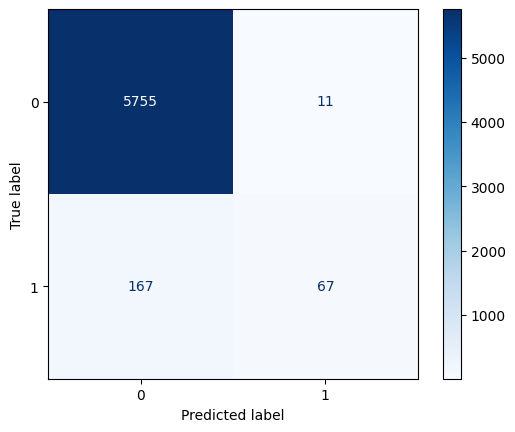

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. Predicciones
y_pred = best_model.predict(X_val)

# 2. Reporte de métricas
print("Classification Report:")
print(classification_report(y_val, y_pred))

# 3. Matriz de confusión
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_val, y_pred))

[[5755   11]
 [ 167   67]]


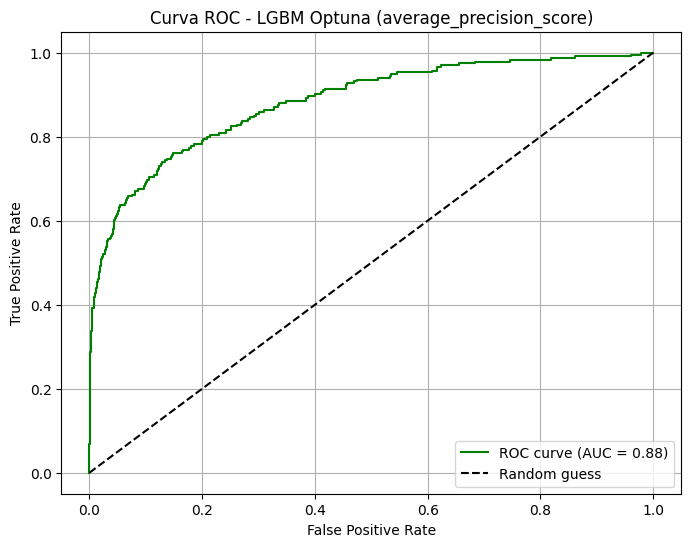

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 1. Obtener probabilidades de clase 1 (fraude)
y_pred_prob = best_model.predict_proba(X_val)[:, 1]

# 2. Calcular puntos ROC y AUC
fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)

# 3. Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - LGBM Optuna (average_precision_score)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
##SUBIDA A KAGGLE
import numpy as np
import pandas as pd

# Tamaño del batch
batch_size = 10000

# Predecir por lotes
y_test_prob = []
for i in range(0, len(test_red), batch_size):
    batch = test_red[i:i + batch_size]
    preds = best_model.predict(batch).ravel()
    y_test_prob.extend(preds)

# Convertir a array de NumPy
y_test_prob = np.array(y_test_prob)

# Aplicar umbral
#y_test_pred = (y_test_prob >= 0.5).astype(int)

# Crear CSV para Kaggle
submission = pd.DataFrame({
    'TransactionID': test_red['TransactionID'],
    'isFraud': y_test_prob
})

submission.to_csv('ModeloOLightGBM_2.csv', index=False)

In [ ]:
from google.colab import files
files.download('ModeloOLightGBM_2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

muy similar

CAMBIAMOS LA METRICA

In [ ]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.metrics import recall_score


def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 15, 128),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'scale_pos_weight': len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  # class weight
        'random_state': 42,
        'n_jobs': -1
    }

    model7C = LGBMClassifier(**params)
    model7C.fit(X_train, y_train)
    y_pred = model7C.predict(X_val)
    return recall_score(y_val, y_pred)

# Ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Ver mejores parámetros
print("Mejores parámetros:")
print(study.best_params)

# Entrenar modelo final con los mejores parámetros
best_model = LGBMClassifier(**study.best_params)
best_model.fit(X_train, y_train)

[I 2025-08-24 11:19:44,437] A new study created in memory with name: no-name-dfade030-2b0d-44b9-a171-0090c519d024
/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13736
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:19:48,426] Trial 0 finished with value: 0.48717948717948717 and parameters: {'n_estimators': 383, 'learning_rate': 0.07096951372671687, 'num_leaves': 23, 'max_depth': 7, 'min_child_samples': 30, 'subsample': 0.8655966424360435, 'colsample_bytree': 0.6124493075833816}. Best is trial 0 with value: 0.48717948717948717.
/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13729
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 112
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:19:49,976] Trial 1 finished with value: 0.7606837606837606 and parameters: {'n_estimators': 234, 'learning_rate': 0.048561312090768693, 'num_leaves': 89, 'max_depth': 3, 'min_child_samples': 42, 'subsample': 0.635527409273, 'colsample_bytree': 0.8802196309077945}. Best is trial 1 with value: 0.7606837606837606.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13751
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073


[I 2025-08-24 11:19:58,982] Trial 2 finished with value: 0.36324786324786323 and parameters: {'n_estimators': 446, 'learning_rate': 0.10107584640804373, 'num_leaves': 51, 'max_depth': 9, 'min_child_samples': 10, 'subsample': 0.6642760527436409, 'colsample_bytree': 0.6656796850965067}. Best is trial 1 with value: 0.7606837606837606.
/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073


[I 2025-08-24 11:20:02,915] Trial 3 finished with value: 0.6068376068376068 and parameters: {'n_estimators': 265, 'learning_rate': 0.016456425719270036, 'num_leaves': 38, 'max_depth': 10, 'min_child_samples': 91, 'subsample': 0.6224135244877489, 'colsample_bytree': 0.8593614536534289}. Best is trial 1 with value: 0.7606837606837606.
/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:20:04,567] Trial 4 finished with value: 0.6581196581196581 and parameters: {'n_estimators': 262, 'learning_rate': 0.10486562293788393, 'num_leaves': 128, 'max_depth': 3, 'min_child_samples': 89, 'subsample': 0.7047216797540752, 'colsample_bytree': 0.813344985139105}. Best is trial 1 with value: 0.7606837606837606.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:20:05,831] Trial 5 finished with value: 0.49572649572649574 and parameters: {'n_estimators': 112, 'learning_rate': 0.012119832149912722, 'num_leaves': 41, 'max_depth': 4, 'min_child_samples': 100, 'subsample': 0.9337500980868509, 'colsample_bytree': 0.9374456630910857}. Best is trial 1 with value: 0.7606837606837606.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13722
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:20:12,653] Trial 6 finished with value: 0.5384615384615384 and parameters: {'n_estimators': 257, 'learning_rate': 0.0408167984723425, 'num_leaves': 83, 'max_depth': 7, 'min_child_samples': 44, 'subsample': 0.9071495103147893, 'colsample_bytree': 0.882942089008564}. Best is trial 1 with value: 0.7606837606837606.
/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13736
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-24 11:20:25,661] Trial 7 finished with value: 0.4829059829059829 and parameters: {'n_estimators': 469, 'learning_rate': 0.0064630215058083095, 'num_leaves': 88, 'max_depth': 10, 'min_child_samples': 30, 'subsample': 0.8627559491940358, 'colsample_bytree': 0.6236481033461113}. Best is trial 1 with value: 0.7606837606837606.
/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:20:30,998] Trial 8 finished with value: 0.3974358974358974 and parameters: {'n_estimators': 311, 'learning_rate': 0.09242828838583687, 'num_leaves': 97, 'max_depth': 10, 'min_child_samples': 93, 'subsample': 0.7353930739014567, 'colsample_bytree': 0.8746787391774828}. Best is trial 1 with value: 0.7606837606837606.
/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13742
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-24 11:20:33,376] Trial 9 finished with value: 0.5085470085470085 and parameters: {'n_estimators': 115, 'learning_rate': 0.018537217186461175, 'num_leaves': 81, 'max_depth': 7, 'min_child_samples': 19, 'subsample': 0.7437270074747229, 'colsample_bytree': 0.858590138202701}. Best is trial 1 with value: 0.7606837606837606.
/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:20:38,309] Trial 10 finished with value: 0.4700854700854701 and parameters: {'n_estimators': 188, 'learning_rate': 0.19178564032799608, 'num_leaves': 110, 'max_depth': 5, 'min_child_samples': 66, 'subsample': 0.6117612313898348, 'colsample_bytree': 0.993489896542504}. Best is trial 1 with value: 0.7606837606837606.
/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:20:39,720] Trial 11 finished with value: 0.7478632478632479 and parameters: {'n_estimators': 216, 'learning_rate': 0.04259610525799019, 'num_leaves': 125, 'max_depth': 3, 'min_child_samples': 69, 'subsample': 0.707152127041685, 'colsample_bytree': 0.7467487684756766}. Best is trial 1 with value: 0.7606837606837606.
/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:20:41,504] Trial 12 finished with value: 0.6709401709401709 and parameters: {'n_estimators': 190, 'learning_rate': 0.0391341651150292, 'num_leaves': 128, 'max_depth': 5, 'min_child_samples': 64, 'subsample': 0.7869869483427258, 'colsample_bytree': 0.7404252434192324}. Best is trial 1 with value: 0.7606837606837606.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13722
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:20:42,857] Trial 13 finished with value: 0.7564102564102564 and parameters: {'n_estimators': 191, 'learning_rate': 0.028727609298686674, 'num_leaves': 66, 'max_depth': 3, 'min_child_samples': 52, 'subsample': 0.672784861605539, 'colsample_bytree': 0.7271137635382178}. Best is trial 1 with value: 0.7606837606837606.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13722
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:20:45,797] Trial 14 finished with value: 0.6581196581196581 and parameters: {'n_estimators': 345, 'learning_rate': 0.023479135188045033, 'num_leaves': 64, 'max_depth': 5, 'min_child_samples': 47, 'subsample': 0.6553460602618273, 'colsample_bytree': 0.7336688308645659}. Best is trial 1 with value: 0.7606837606837606.
/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13722
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073


[I 2025-08-24 11:20:52,518] Trial 15 finished with value: 0.4829059829059829 and parameters: {'n_estimators': 166, 'learning_rate': 0.009526411905259583, 'num_leaves': 68, 'max_depth': 12, 'min_child_samples': 53, 'subsample': 0.9964797981019948, 'colsample_bytree': 0.7925493102052433}. Best is trial 1 with value: 0.7606837606837606.
/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13736
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:20:53,604] Trial 16 finished with value: 0.7521367521367521 and parameters: {'n_estimators': 147, 'learning_rate': 0.06060051716641426, 'num_leaves': 101, 'max_depth': 3, 'min_child_samples': 39, 'subsample': 0.7893600262843845, 'colsample_bytree': 0.6966854328200678}. Best is trial 1 with value: 0.7606837606837606.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:20:56,315] Trial 17 finished with value: 0.6324786324786325 and parameters: {'n_estimators': 226, 'learning_rate': 0.02342275885399464, 'num_leaves': 58, 'max_depth': 6, 'min_child_samples': 75, 'subsample': 0.6674547068413944, 'colsample_bytree': 0.7978651528883813}. Best is trial 1 with value: 0.7606837606837606.
/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13714
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 110
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:20:58,594] Trial 18 finished with value: 0.4658119658119658 and parameters: {'n_estimators': 313, 'learning_rate': 0.1684860135650783, 'num_leaves': 76, 'max_depth': 4, 'min_child_samples': 57, 'subsample': 0.6035844856574875, 'colsample_bytree': 0.9322664578098031}. Best is trial 1 with value: 0.7606837606837606.
/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13736
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:21:04,542] Trial 19 finished with value: 0.6923076923076923 and parameters: {'n_estimators': 373, 'learning_rate': 0.028329972402544815, 'num_leaves': 16, 'max_depth': 4, 'min_child_samples': 32, 'subsample': 0.7541344351686461, 'colsample_bytree': 0.9350674689978387}. Best is trial 1 with value: 0.7606837606837606.
/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:21:07,168] Trial 20 finished with value: 0.5641025641025641 and parameters: {'n_estimators': 243, 'learning_rate': 0.05955307323728939, 'num_leaves': 108, 'max_depth': 6, 'min_child_samples': 78, 'subsample': 0.7013436160283156, 'colsample_bytree': 0.8266206662831316}. Best is trial 1 with value: 0.7606837606837606.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13729
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 112
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:21:08,324] Trial 21 finished with value: 0.7564102564102564 and parameters: {'n_estimators': 155, 'learning_rate': 0.057391481992559494, 'num_leaves': 94, 'max_depth': 3, 'min_child_samples': 40, 'subsample': 0.8484539143686872, 'colsample_bytree': 0.6903819223597623}. Best is trial 1 with value: 0.7606837606837606.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13722
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:21:09,435] Trial 22 finished with value: 0.7649572649572649 and parameters: {'n_estimators': 152, 'learning_rate': 0.050765362127726414, 'num_leaves': 94, 'max_depth': 3, 'min_child_samples': 54, 'subsample': 0.8362472294747101, 'colsample_bytree': 0.6750779223674653}. Best is trial 22 with value: 0.7649572649572649.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13722
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:21:11,023] Trial 23 finished with value: 0.7222222222222222 and parameters: {'n_estimators': 199, 'learning_rate': 0.034194465753520906, 'num_leaves': 73, 'max_depth': 4, 'min_child_samples': 55, 'subsample': 0.822727694296134, 'colsample_bytree': 0.6670825714213229}. Best is trial 22 with value: 0.7649572649572649.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13722
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:21:12,123] Trial 24 finished with value: 0.7777777777777778 and parameters: {'n_estimators': 139, 'learning_rate': 0.044756446148990645, 'num_leaves': 113, 'max_depth': 3, 'min_child_samples': 49, 'subsample': 0.6444020617740954, 'colsample_bytree': 0.7126141601321666}. Best is trial 24 with value: 0.7777777777777778.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:21:13,393] Trial 25 finished with value: 0.7222222222222222 and parameters: {'n_estimators': 102, 'learning_rate': 0.04936734685096257, 'num_leaves': 113, 'max_depth': 5, 'min_child_samples': 61, 'subsample': 0.9137351462998284, 'colsample_bytree': 0.6496962000316673}. Best is trial 24 with value: 0.7777777777777778.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13736
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:21:17,850] Trial 26 finished with value: 0.6623931623931624 and parameters: {'n_estimators': 135, 'learning_rate': 0.08104947089061143, 'num_leaves': 115, 'max_depth': 4, 'min_child_samples': 37, 'subsample': 0.7690574619289149, 'colsample_bytree': 0.7749535862159558}. Best is trial 24 with value: 0.7777777777777778.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13742
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:21:19,816] Trial 27 finished with value: 0.44871794871794873 and parameters: {'n_estimators': 171, 'learning_rate': 0.12499233419589088, 'num_leaves': 103, 'max_depth': 6, 'min_child_samples': 21, 'subsample': 0.8316750346636725, 'colsample_bytree': 0.7007433979253068}. Best is trial 24 with value: 0.7777777777777778.
/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:21:23,768] Trial 28 finished with value: 0.3888888888888889 and parameters: {'n_estimators': 280, 'learning_rate': 0.1414576933690148, 'num_leaves': 88, 'max_depth': 8, 'min_child_samples': 75, 'subsample': 0.6335715837742898, 'colsample_bytree': 0.7723142210501877}. Best is trial 24 with value: 0.7777777777777778.
/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13722
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:21:24,986] Trial 29 finished with value: 0.7393162393162394 and parameters: {'n_estimators': 133, 'learning_rate': 0.06657081744410695, 'num_leaves': 118, 'max_depth': 3, 'min_child_samples': 47, 'subsample': 0.81383482702285, 'colsample_bytree': 0.6316290268056252}. Best is trial 24 with value: 0.7777777777777778.
/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13736
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:21:26,830] Trial 30 finished with value: 0.6752136752136753 and parameters: {'n_estimators': 223, 'learning_rate': 0.0508792178862175, 'num_leaves': 92, 'max_depth': 4, 'min_child_samples': 30, 'subsample': 0.8943276173772997, 'colsample_bytree': 0.8356424068849929}. Best is trial 24 with value: 0.7777777777777778.
/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13722
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:21:31,441] Trial 31 finished with value: 0.7649572649572649 and parameters: {'n_estimators': 192, 'learning_rate': 0.03012046255075576, 'num_leaves': 103, 'max_depth': 3, 'min_child_samples': 51, 'subsample': 0.6456374828209266, 'colsample_bytree': 0.7206624610107143}. Best is trial 24 with value: 0.7777777777777778.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13722
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:21:32,620] Trial 32 finished with value: 0.7435897435897436 and parameters: {'n_estimators': 165, 'learning_rate': 0.0748791336855719, 'num_leaves': 103, 'max_depth': 3, 'min_child_samples': 46, 'subsample': 0.6424040196475188, 'colsample_bytree': 0.6753776307805823}. Best is trial 24 with value: 0.7777777777777778.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13722
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:21:34,304] Trial 33 finished with value: 0.7051282051282052 and parameters: {'n_estimators': 206, 'learning_rate': 0.03509982735102759, 'num_leaves': 106, 'max_depth': 4, 'min_child_samples': 51, 'subsample': 0.6840787952825319, 'colsample_bytree': 0.7116969729568231}. Best is trial 24 with value: 0.7777777777777778.
/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13714
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 110
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:21:36,475] Trial 34 finished with value: 0.7521367521367521 and parameters: {'n_estimators': 238, 'learning_rate': 0.02156211990200909, 'num_leaves': 118, 'max_depth': 3, 'min_child_samples': 59, 'subsample': 0.6308383730206016, 'colsample_bytree': 0.6061686955164259}. Best is trial 24 with value: 0.7777777777777778.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13736
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:21:38,180] Trial 35 finished with value: 0.5897435897435898 and parameters: {'n_estimators': 132, 'learning_rate': 0.013761704974958135, 'num_leaves': 98, 'max_depth': 5, 'min_child_samples': 36, 'subsample': 0.7271122266276423, 'colsample_bytree': 0.7628581061996687}. Best is trial 24 with value: 0.7777777777777778.
/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13722
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:21:40,998] Trial 36 finished with value: 0.49145299145299143 and parameters: {'n_estimators': 181, 'learning_rate': 0.04561402982143014, 'num_leaves': 85, 'max_depth': 8, 'min_child_samples': 43, 'subsample': 0.6904951951461373, 'colsample_bytree': 0.6448537409983314}. Best is trial 24 with value: 0.7777777777777778.
/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13742
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:21:50,087] Trial 37 finished with value: 0.42735042735042733 and parameters: {'n_estimators': 294, 'learning_rate': 0.03400091897866489, 'num_leaves': 78, 'max_depth': 12, 'min_child_samples': 24, 'subsample': 0.657523835788677, 'colsample_bytree': 0.6781029686309363}. Best is trial 24 with value: 0.7777777777777778.
/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:21:52,100] Trial 38 finished with value: 0.6068376068376068 and parameters: {'n_estimators': 266, 'learning_rate': 0.08965771474406448, 'num_leaves': 92, 'max_depth': 4, 'min_child_samples': 70, 'subsample': 0.8834175560590187, 'colsample_bytree': 0.9112353655137291}. Best is trial 24 with value: 0.7777777777777778.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13722
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:21:55,179] Trial 39 finished with value: 0.7435897435897436 and parameters: {'n_estimators': 497, 'learning_rate': 0.027985922044667547, 'num_leaves': 37, 'max_depth': 3, 'min_child_samples': 50, 'subsample': 0.9615794281364258, 'colsample_bytree': 0.9854696094127264}. Best is trial 24 with value: 0.7777777777777778.
/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.322482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13729
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 112
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073


[I 2025-08-24 11:22:01,245] Trial 40 finished with value: 0.41025641025641024 and parameters: {'n_estimators': 111, 'learning_rate': 0.01689597982978863, 'num_leaves': 122, 'max_depth': 11, 'min_child_samples': 42, 'subsample': 0.600046480495979, 'colsample_bytree': 0.7155708278247125}. Best is trial 24 with value: 0.7777777777777778.
/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13722
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:22:02,449] Trial 41 finished with value: 0.7606837606837606 and parameters: {'n_estimators': 151, 'learning_rate': 0.02906594561493252, 'num_leaves': 50, 'max_depth': 3, 'min_child_samples': 53, 'subsample': 0.6763987476808323, 'colsample_bytree': 0.7252333136475284}. Best is trial 24 with value: 0.7777777777777778.
/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:22:03,632] Trial 42 finished with value: 0.7521367521367521 and parameters: {'n_estimators': 149, 'learning_rate': 0.037916133116844115, 'num_leaves': 47, 'max_depth': 3, 'min_child_samples': 62, 'subsample': 0.6433888454258009, 'colsample_bytree': 0.7625117157829385}. Best is trial 24 with value: 0.7777777777777778.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13714
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 110
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:22:04,807] Trial 43 finished with value: 0.717948717948718 and parameters: {'n_estimators': 128, 'learning_rate': 0.05149322156996784, 'num_leaves': 30, 'max_depth': 4, 'min_child_samples': 57, 'subsample': 0.7187597412367902, 'colsample_bytree': 0.7225705491192198}. Best is trial 24 with value: 0.7777777777777778.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13751
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:22:06,308] Trial 44 finished with value: 0.7478632478632479 and parameters: {'n_estimators': 208, 'learning_rate': 0.021554211379469078, 'num_leaves': 55, 'max_depth': 3, 'min_child_samples': 12, 'subsample': 0.6226507168351398, 'colsample_bytree': 0.6496996691223839}. Best is trial 24 with value: 0.7777777777777778.
/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13722
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:22:08,120] Trial 45 finished with value: 0.6623931623931624 and parameters: {'n_estimators': 171, 'learning_rate': 0.04292569205924, 'num_leaves': 98, 'max_depth': 5, 'min_child_samples': 49, 'subsample': 0.6736060408994802, 'colsample_bytree': 0.9016476722364939}. Best is trial 24 with value: 0.7777777777777778.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13722
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:22:13,776] Trial 46 finished with value: 0.5085470085470085 and parameters: {'n_estimators': 122, 'learning_rate': 0.02929988462815427, 'num_leaves': 81, 'max_depth': 9, 'min_child_samples': 45, 'subsample': 0.6191929892358079, 'colsample_bytree': 0.7494496629292604}. Best is trial 24 with value: 0.7777777777777778.
/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:22:15,703] Trial 47 finished with value: 0.6923076923076923 and parameters: {'n_estimators': 249, 'learning_rate': 0.010020063631038975, 'num_leaves': 88, 'max_depth': 3, 'min_child_samples': 66, 'subsample': 0.6500474171063739, 'colsample_bytree': 0.8546717184711605}. Best is trial 24 with value: 0.7777777777777778.
/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13736
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:22:18,767] Trial 48 finished with value: 0.4829059829059829 and parameters: {'n_estimators': 427, 'learning_rate': 0.10438625194923334, 'num_leaves': 111, 'max_depth': 4, 'min_child_samples': 34, 'subsample': 0.861293712397909, 'colsample_bytree': 0.9739963122337512}. Best is trial 24 with value: 0.7777777777777778.
/tmp/ipython-input-1413397260.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13722
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:22:19,908] Trial 49 finished with value: 0.7393162393162394 and parameters: {'n_estimators': 152, 'learning_rate': 0.06928630746650992, 'num_leaves': 41, 'max_depth': 3, 'min_child_samples': 55, 'subsample': 0.6987167261666701, 'colsample_bytree': 0.6877166600421813}. Best is trial 24 with value: 0.7777777777777778.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMClassifier(colsample_bytree=0.7126141601321666,
               learning_rate=0.044756446148990645, max_depth=3,
               min_child_samples=49, n_estimators=139, num_leaves=113,
               subsample=0.6444020617740954)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5766
           1       0.86      0.24      0.37       234

    accuracy                           0.97      6000
   macro avg       0.91      0.62      0.68      6000
weighted avg       0.97      0.97      0.96      6000



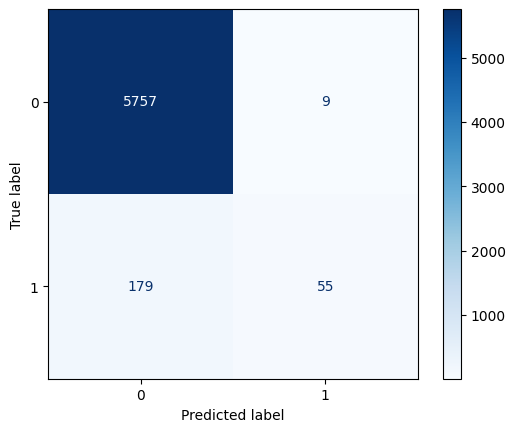

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. Predicciones
y_pred = best_model.predict(X_val)

# 2. Reporte de métricas
print("Classification Report:")
print(classification_report(y_val, y_pred))

# 3. Matriz de confusión
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_val, y_pred))

[[5757    9]
 [ 179   55]]


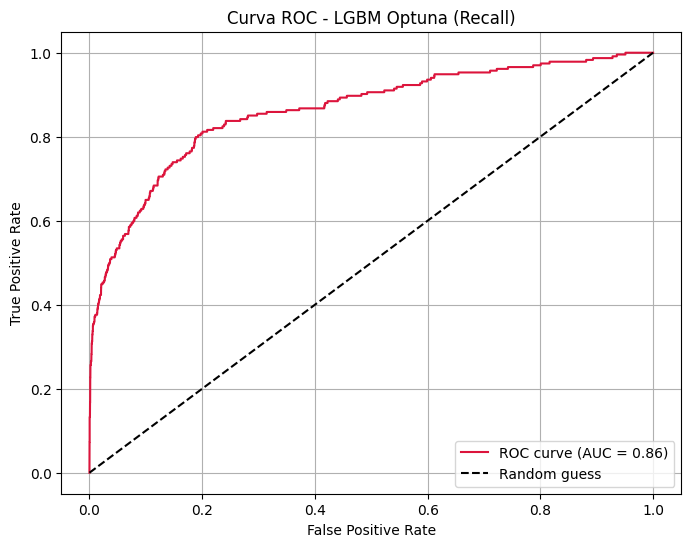

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 1. Probabilidades de clase 1 (fraude)
y_pred_prob = best_model.predict_proba(X_val)[:, 1]

# 2. Calcular puntos de la curva ROC
fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)

# 3. Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='crimson')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - LGBM Optuna (Recall)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
##SUBIDA A KAGGLE
import numpy as np
import pandas as pd

# Tamaño del batch
batch_size = 10000

# Predecir por lotes
y_test_prob = []
for i in range(0, len(test_red), batch_size):
    batch = test_red[i:i + batch_size]
    preds = best_model.predict(batch).ravel()
    y_test_prob.extend(preds)

# Convertir a array de NumPy
y_test_prob = np.array(y_test_prob)

# Aplicar umbral
#y_test_pred = (y_test_prob >= 0.5).astype(int)

# Crear CSV para Kaggle
submission = pd.DataFrame({
    'TransactionID': test_red['TransactionID'],
    'isFraud': y_test_prob
})

submission.to_csv('ModeloOLightGBM_3.csv', index=False)

In [ ]:
from google.colab import files
files.download('ModeloOLightGBM_3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

optimizar AUC

In [ ]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 15, 128),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'scale_pos_weight': len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
        'random_state': 42,
        'n_jobs': -1
    }

    model = LGBMClassifier(**params)
    model.fit(X_train, y_train)

    # Probabilidades de la clase positiva
    y_proba = model.predict_proba(X_val)[:, 1]

    # Retornar AUC ROC
    return roc_auc_score(y_val, y_proba)

# Ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Ver mejores parámetros
print("Mejores parámetros:")
print(study.best_params)

# Entrenar modelo final con los mejores parámetros
best_model = LGBMClassifier(**study.best_params)
best_model.fit(X_train, y_train)


[I 2025-08-24 11:25:00,417] A new study created in memory with name: no-name-73a2d8a0-8eeb-407e-8196-12d1a2c81d54
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13729
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 112
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-24 11:25:05,433] Trial 0 finished with value: 0.8802944463714495 and parameters: {'n_estimators': 304, 'learning_rate': 0.02694332620171743, 'num_leaves': 53, 'max_depth': 11, 'min_child_samples': 40, 'subsample': 0.8968898483944172, 'colsample_bytree': 0.61540948990268}. Best is trial 0 with value: 0.8802944463714495.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:25:17,298] Trial 1 finished with value: 0.8777063303598163 and parameters: {'n_estimators': 461, 'learning_rate': 0.011826609410521298, 'num_leaves': 118, 'max_depth': 11, 'min_child_samples': 99, 'subsample': 0.7438863017894202, 'colsample_bytree': 0.7515635364731718}. Best is trial 0 with value: 0.8802944463714495.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13742
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073


[I 2025-08-24 11:25:20,009] Trial 2 finished with value: 0.8762195718491244 and parameters: {'n_estimators': 293, 'learning_rate': 0.02793851319390058, 'num_leaves': 16, 'max_depth': 9, 'min_child_samples': 19, 'subsample': 0.9719169605321725, 'colsample_bytree': 0.7778970383355335}. Best is trial 0 with value: 0.8802944463714495.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13748
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073


[I 2025-08-24 11:25:28,350] Trial 3 finished with value: 0.8682506648167418 and parameters: {'n_estimators': 331, 'learning_rate': 0.005563432413706155, 'num_leaves': 47, 'max_depth': 9, 'min_child_samples': 16, 'subsample': 0.8647890462812585, 'colsample_bytree': 0.738963085504259}. Best is trial 0 with value: 0.8802944463714495.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13736
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:25:31,198] Trial 4 finished with value: 0.8575635689319351 and parameters: {'n_estimators': 499, 'learning_rate': 0.00621106753260846, 'num_leaves': 15, 'max_depth': 3, 'min_child_samples': 31, 'subsample': 0.6691535946540041, 'colsample_bytree': 0.6718414612734301}. Best is trial 0 with value: 0.8802944463714495.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13748
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073


[I 2025-08-24 11:25:37,342] Trial 5 finished with value: 0.8768162022584499 and parameters: {'n_estimators': 430, 'learning_rate': 0.046293244348349784, 'num_leaves': 44, 'max_depth': 12, 'min_child_samples': 18, 'subsample': 0.811037407156664, 'colsample_bytree': 0.7363366378599471}. Best is trial 0 with value: 0.8802944463714495.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.216120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:25:43,075] Trial 6 finished with value: 0.8780939548369309 and parameters: {'n_estimators': 344, 'learning_rate': 0.02596823863531009, 'num_leaves': 55, 'max_depth': 5, 'min_child_samples': 79, 'subsample': 0.7056542469094544, 'colsample_bytree': 0.7123971617829737}. Best is trial 0 with value: 0.8802944463714495.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:25:46,235] Trial 7 finished with value: 0.8554790682782357 and parameters: {'n_estimators': 222, 'learning_rate': 0.13690506214234283, 'num_leaves': 102, 'max_depth': 8, 'min_child_samples': 90, 'subsample': 0.7650212499056339, 'colsample_bytree': 0.701273265233143}. Best is trial 0 with value: 0.8802944463714495.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:25:56,900] Trial 8 finished with value: 0.8768918001488241 and parameters: {'n_estimators': 492, 'learning_rate': 0.026999292066572984, 'num_leaves': 83, 'max_depth': 9, 'min_child_samples': 94, 'subsample': 0.8831188430286683, 'colsample_bytree': 0.6136735699966103}. Best is trial 0 with value: 0.8802944463714495.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13751
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-24 11:26:02,667] Trial 9 finished with value: 0.8783429831816929 and parameters: {'n_estimators': 385, 'learning_rate': 0.038411290383844256, 'num_leaves': 47, 'max_depth': 9, 'min_child_samples': 13, 'subsample': 0.978210938471672, 'colsample_bytree': 0.604156220748923}. Best is trial 0 with value: 0.8802944463714495.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13722
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:26:05,777] Trial 10 finished with value: 0.8556621337578674 and parameters: {'n_estimators': 120, 'learning_rate': 0.09406716453313646, 'num_leaves': 77, 'max_depth': 6, 'min_child_samples': 48, 'subsample': 0.6264030519974783, 'colsample_bytree': 0.8963770689404078}. Best is trial 0 with value: 0.8802944463714495.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13722
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:26:13,700] Trial 11 finished with value: 0.8727857970834036 and parameters: {'n_estimators': 374, 'learning_rate': 0.05396609226639693, 'num_leaves': 59, 'max_depth': 11, 'min_child_samples': 45, 'subsample': 0.9862051467714599, 'colsample_bytree': 0.6008344552112266}. Best is trial 0 with value: 0.8802944463714495.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073


[I 2025-08-24 11:26:17,208] Trial 12 finished with value: 0.8737159475973212 and parameters: {'n_estimators': 251, 'learning_rate': 0.015015745406439228, 'num_leaves': 31, 'max_depth': 11, 'min_child_samples': 68, 'subsample': 0.9230367911063593, 'colsample_bytree': 0.9024225569711655}. Best is trial 0 with value: 0.8802944463714495.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13736
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:26:28,200] Trial 13 finished with value: 0.862517083640913 and parameters: {'n_estimators': 410, 'learning_rate': 0.06332155462720775, 'num_leaves': 71, 'max_depth': 10, 'min_child_samples': 38, 'subsample': 0.9264482047064468, 'colsample_bytree': 0.9908648401499592}. Best is trial 0 with value: 0.8802944463714495.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13714
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 110
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073


[I 2025-08-24 11:26:30,761] Trial 14 finished with value: 0.8755792132483079 and parameters: {'n_estimators': 201, 'learning_rate': 0.01575836596264181, 'num_leaves': 34, 'max_depth': 7, 'min_child_samples': 60, 'subsample': 0.8578035993973321, 'colsample_bytree': 0.6512518354929695}. Best is trial 0 with value: 0.8802944463714495.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13736
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:26:40,238] Trial 15 finished with value: 0.8671367076674048 and parameters: {'n_estimators': 288, 'learning_rate': 0.17723004255149596, 'num_leaves': 90, 'max_depth': 12, 'min_child_samples': 33, 'subsample': 0.9394713858685111, 'colsample_bytree': 0.8391974183223095}. Best is trial 0 with value: 0.8802944463714495.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13751
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:26:45,218] Trial 16 finished with value: 0.8596969858676414 and parameters: {'n_estimators': 387, 'learning_rate': 0.03955244330633703, 'num_leaves': 61, 'max_depth': 7, 'min_child_samples': 10, 'subsample': 0.9984157184258351, 'colsample_bytree': 0.650465974146347}. Best is trial 0 with value: 0.8802944463714495.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.342355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13736
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-24 11:26:50,371] Trial 17 finished with value: 0.8751085793229395 and parameters: {'n_estimators': 165, 'learning_rate': 0.07345284152833512, 'num_leaves': 35, 'max_depth': 10, 'min_child_samples': 26, 'subsample': 0.8240203731682052, 'colsample_bytree': 0.8103874983508862}. Best is trial 0 with value: 0.8802944463714495.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13714
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 110
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:26:55,418] Trial 18 finished with value: 0.8698033861925641 and parameters: {'n_estimators': 333, 'learning_rate': 0.01872278220943035, 'num_leaves': 67, 'max_depth': 8, 'min_child_samples': 59, 'subsample': 0.8925817058326424, 'colsample_bytree': 0.6351018298877407}. Best is trial 0 with value: 0.8802944463714495.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13722
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073


[I 2025-08-24 11:27:02,523] Trial 19 finished with value: 0.8741480414217146 and parameters: {'n_estimators': 262, 'learning_rate': 0.010567519397963666, 'num_leaves': 49, 'max_depth': 10, 'min_child_samples': 44, 'subsample': 0.950602527323547, 'colsample_bytree': 0.6863168436793279}. Best is trial 0 with value: 0.8802944463714495.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:27:06,247] Trial 20 finished with value: 0.87615138551663 and parameters: {'n_estimators': 440, 'learning_rate': 0.03510182443288529, 'num_leaves': 99, 'max_depth': 5, 'min_child_samples': 70, 'subsample': 0.9048091817435127, 'colsample_bytree': 0.8565398719854151}. Best is trial 0 with value: 0.8802944463714495.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:27:08,689] Trial 21 finished with value: 0.8756829750586255 and parameters: {'n_estimators': 347, 'learning_rate': 0.022432523368635084, 'num_leaves': 58, 'max_depth': 4, 'min_child_samples': 81, 'subsample': 0.7037513647584012, 'colsample_bytree': 0.713716721418766}. Best is trial 0 with value: 0.8802944463714495.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:27:12,346] Trial 22 finished with value: 0.8772394022133875 and parameters: {'n_estimators': 360, 'learning_rate': 0.032565247977479304, 'num_leaves': 49, 'max_depth': 5, 'min_child_samples': 81, 'subsample': 0.6124042785160845, 'colsample_bytree': 0.6055717101086915}. Best is trial 0 with value: 0.8802944463714495.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13722
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:27:18,068] Trial 23 finished with value: 0.8695180412141911 and parameters: {'n_estimators': 311, 'learning_rate': 0.0842423776147809, 'num_leaves': 39, 'max_depth': 6, 'min_child_samples': 52, 'subsample': 0.7168251373086225, 'colsample_bytree': 0.6662008899676138}. Best is trial 0 with value: 0.8802944463714495.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:27:20,651] Trial 24 finished with value: 0.8693379403577114 and parameters: {'n_estimators': 383, 'learning_rate': 0.02095426100585335, 'num_leaves': 27, 'max_depth': 3, 'min_child_samples': 71, 'subsample': 0.7916366014427696, 'colsample_bytree': 0.6311323307924972}. Best is trial 0 with value: 0.8802944463714495.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:27:29,487] Trial 25 finished with value: 0.8744571033853031 and parameters: {'n_estimators': 407, 'learning_rate': 0.008715250845718923, 'num_leaves': 57, 'max_depth': 8, 'min_child_samples': 80, 'subsample': 0.8395844815054309, 'colsample_bytree': 0.6984234238359364}. Best is trial 0 with value: 0.8802944463714495.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13736
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:27:32,664] Trial 26 finished with value: 0.8668587742469117 and parameters: {'n_estimators': 266, 'learning_rate': 0.05006480411398118, 'num_leaves': 67, 'max_depth': 6, 'min_child_samples': 27, 'subsample': 0.6726062740895579, 'colsample_bytree': 0.6356452996590405}. Best is trial 0 with value: 0.8802944463714495.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13736
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:27:35,036] Trial 27 finished with value: 0.8719875722997471 and parameters: {'n_estimators': 322, 'learning_rate': 0.023966835336224245, 'num_leaves': 25, 'max_depth': 4, 'min_child_samples': 38, 'subsample': 0.9653367040180139, 'colsample_bytree': 0.7633608787855666}. Best is trial 0 with value: 0.8802944463714495.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13751
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-24 11:27:42,725] Trial 28 finished with value: 0.8666897907272517 and parameters: {'n_estimators': 232, 'learning_rate': 0.037698464821560355, 'num_leaves': 81, 'max_depth': 10, 'min_child_samples': 11, 'subsample': 0.7875866429524558, 'colsample_bytree': 0.7115411006921833}. Best is trial 0 with value: 0.8802944463714495.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:27:52,471] Trial 29 finished with value: 0.8730778124638688 and parameters: {'n_estimators': 466, 'learning_rate': 0.01341824906859956, 'num_leaves': 119, 'max_depth': 12, 'min_child_samples': 61, 'subsample': 0.7398281541625736, 'colsample_bytree': 0.6723873040925721}. Best is trial 0 with value: 0.8802944463714495.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-24 11:28:01,308] Trial 30 finished with value: 0.8787387603724752 and parameters: {'n_estimators': 354, 'learning_rate': 0.009631084966383178, 'num_leaves': 51, 'max_depth': 11, 'min_child_samples': 100, 'subsample': 0.6720094051368903, 'colsample_bytree': 0.7855571653224752}. Best is trial 0 with value: 0.8802944463714495.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-24 11:28:10,357] Trial 31 finished with value: 0.8746935320816693 and parameters: {'n_estimators': 361, 'learning_rate': 0.008128058055127122, 'num_leaves': 53, 'max_depth': 11, 'min_child_samples': 100, 'subsample': 0.6466968350831863, 'colsample_bytree': 0.7874805792204376}. Best is trial 0 with value: 0.8802944463714495.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:28:14,506] Trial 32 finished with value: 0.8805723797919427 and parameters: {'n_estimators': 296, 'learning_rate': 0.018386847456265076, 'num_leaves': 40, 'max_depth': 9, 'min_child_samples': 90, 'subsample': 0.6940639980495604, 'colsample_bytree': 0.8247470148387717}. Best is trial 32 with value: 0.8805723797919427.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-24 11:28:18,704] Trial 33 finished with value: 0.8747795061530753 and parameters: {'n_estimators': 290, 'learning_rate': 0.011070325218582516, 'num_leaves': 40, 'max_depth': 9, 'min_child_samples': 91, 'subsample': 0.6728362435799105, 'colsample_bytree': 0.8216127405967929}. Best is trial 32 with value: 0.8805723797919427.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:28:29,288] Trial 34 finished with value: 0.8657737221733061 and parameters: {'n_estimators': 301, 'learning_rate': 0.00739819683535318, 'num_leaves': 128, 'max_depth': 10, 'min_child_samples': 96, 'subsample': 0.7455658855263171, 'colsample_bytree': 0.8744509312104621}. Best is trial 32 with value: 0.8805723797919427.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13742
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073


[I 2025-08-24 11:28:37,289] Trial 35 finished with value: 0.866267331928102 and parameters: {'n_estimators': 402, 'learning_rate': 0.005146752884407964, 'num_leaves': 20, 'max_depth': 11, 'min_child_samples': 23, 'subsample': 0.644855920414821, 'colsample_bytree': 0.9377104668002487}. Best is trial 32 with value: 0.8805723797919427.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-24 11:28:41,080] Trial 36 finished with value: 0.8773779983457403 and parameters: {'n_estimators': 273, 'learning_rate': 0.01559068527216156, 'num_leaves': 44, 'max_depth': 9, 'min_child_samples': 88, 'subsample': 0.8644503512354161, 'colsample_bytree': 0.7425381477644526}. Best is trial 32 with value: 0.8805723797919427.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:28:46,603] Trial 37 finished with value: 0.8787217137893518 and parameters: {'n_estimators': 317, 'learning_rate': 0.01911262309088685, 'num_leaves': 63, 'max_depth': 12, 'min_child_samples': 85, 'subsample': 0.6903807016604754, 'colsample_bytree': 0.788689407726678}. Best is trial 32 with value: 0.8805723797919427.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:28:55,107] Trial 38 finished with value: 0.876769509443807 and parameters: {'n_estimators': 319, 'learning_rate': 0.01831372790249412, 'num_leaves': 64, 'max_depth': 12, 'min_child_samples': 86, 'subsample': 0.6946027631455974, 'colsample_bytree': 0.770693940403864}. Best is trial 32 with value: 0.8805723797919427.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13707
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073


[I 2025-08-24 11:28:58,628] Trial 39 finished with value: 0.8713479548547187 and parameters: {'n_estimators': 197, 'learning_rate': 0.012353353589775663, 'num_leaves': 52, 'max_depth': 12, 'min_child_samples': 75, 'subsample': 0.7292099326650827, 'colsample_bytree': 0.7933600684229902}. Best is trial 32 with value: 0.8805723797919427.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-24 11:29:08,517] Trial 40 finished with value: 0.8671804358588958 and parameters: {'n_estimators': 340, 'learning_rate': 0.0063759934300572215, 'num_leaves': 73, 'max_depth': 11, 'min_child_samples': 96, 'subsample': 0.6852530339724653, 'colsample_bytree': 0.8233508446012493}. Best is trial 32 with value: 0.8805723797919427.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:29:13,487] Trial 41 finished with value: 0.8779309005635749 and parameters: {'n_estimators': 364, 'learning_rate': 0.028067387282157647, 'num_leaves': 44, 'max_depth': 9, 'min_child_samples': 86, 'subsample': 0.64587157012152, 'colsample_bytree': 0.8489012838852512}. Best is trial 32 with value: 0.8805723797919427.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:29:20,321] Trial 42 finished with value: 0.8816737372928841 and parameters: {'n_estimators': 283, 'learning_rate': 0.04386085046967839, 'num_leaves': 42, 'max_depth': 10, 'min_child_samples': 94, 'subsample': 0.7764718770152002, 'colsample_bytree': 0.7250054671356312}. Best is trial 42 with value: 0.8816737372928841.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:29:23,636] Trial 43 finished with value: 0.8824860440365122 and parameters: {'n_estimators': 245, 'learning_rate': 0.02940334476106, 'num_leaves': 39, 'max_depth': 11, 'min_child_samples': 100, 'subsample': 0.7719262029165569, 'colsample_bytree': 0.7280272927937003}. Best is trial 43 with value: 0.8824860440365122.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:29:27,015] Trial 44 finished with value: 0.8822155221738988 and parameters: {'n_estimators': 242, 'learning_rate': 0.0287469583802656, 'num_leaves': 39, 'max_depth': 11, 'min_child_samples': 100, 'subsample': 0.7596743311027171, 'colsample_bytree': 0.757728530009615}. Best is trial 43 with value: 0.8824860440365122.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-08-24 11:29:33,516] Trial 45 finished with value: 0.8821754997613479 and parameters: {'n_estimators': 242, 'learning_rate': 0.029267085938157914, 'num_leaves': 39, 'max_depth': 10, 'min_child_samples': 92, 'subsample': 0.7623898726346388, 'colsample_bytree': 0.7267152020802607}. Best is trial 43 with value: 0.8824860440365122.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-24 11:29:36,109] Trial 46 finished with value: 0.8795525494276796 and parameters: {'n_estimators': 237, 'learning_rate': 0.029373471593834945, 'num_leaves': 23, 'max_depth': 10, 'min_child_samples': 93, 'subsample': 0.7640436051960307, 'colsample_bytree': 0.729317461570651}. Best is trial 43 with value: 0.8824860440365122.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-24 11:29:38,764] Trial 47 finished with value: 0.8788477102733087 and parameters: {'n_estimators': 186, 'learning_rate': 0.044215753649272764, 'num_leaves': 38, 'max_depth': 11, 'min_child_samples': 96, 'subsample': 0.7770215044605548, 'colsample_bytree': 0.7554349181462203}. Best is trial 43 with value: 0.8824860440365122.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-24 11:29:44,606] Trial 48 finished with value: 0.879694851338972 and parameters: {'n_estimators': 221, 'learning_rate': 0.05869717296712637, 'num_leaves': 30, 'max_depth': 10, 'min_child_samples': 92, 'subsample': 0.753916649475484, 'colsample_bytree': 0.7280995632194052}. Best is trial 43 with value: 0.8824860440365122.
/tmp/ipython-input-1777715217.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),


[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073


[I 2025-08-24 11:29:46,480] Trial 49 finished with value: 0.8771541692977697 and parameters: {'n_estimators': 166, 'learning_rate': 0.025850065409770046, 'num_leaves': 19, 'max_depth': 9, 'min_child_samples': 97, 'subsample': 0.8039241386148075, 'colsample_bytree': 0.7452838508217611}. Best is trial 43 with value: 0.8824860440365122.


Mejores parámetros:
{'n_estimators': 245, 'learning_rate': 0.02940334476106, 'num_leaves': 39, 'max_depth': 11, 'min_child_samples': 100, 'subsample': 0.7719262029165569, 'colsample_bytree': 0.7280272927937003}
[LightGBM] [Info] Number of positive: 815, number of negative: 23185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13698
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033958 -> initscore=-3.348073
[LightGBM] [Info] Start training from score -3.348073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

LGBMClassifier(colsample_bytree=0.7280272927937003,
               learning_rate=0.02940334476106, max_depth=11,
               min_child_samples=100, n_estimators=245, num_leaves=39,
               subsample=0.7719262029165569)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. Predicciones
y_pred = best_model.predict(X_val)

# 2. Reporte de métricas
print("Classification Report:")
print(classification_report(y_val, y_pred))

# 3. Matriz de confusión
print(confusion_matrix(y_val, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5766
           1       0.83      0.29      0.43       234

    accuracy                           0.97      6000
   macro avg       0.90      0.64      0.71      6000
weighted avg       0.97      0.97      0.96      6000

[[5752   14]
 [ 166   68]]


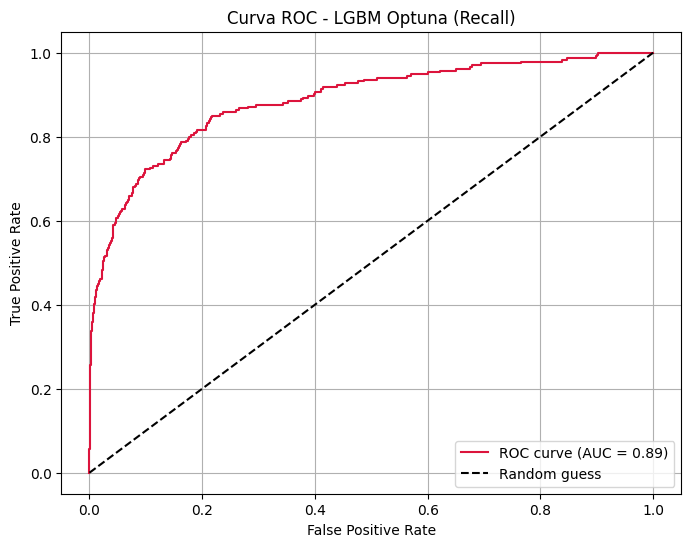

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 1. Probabilidades de clase 1 (fraude)
y_pred_prob = best_model.predict_proba(X_val)[:, 1]

# 2. Calcular puntos de la curva ROC
fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)

# 3. Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='crimson')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - LGBM Optuna (Recall)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
##SUBIDA A KAGGLE
import numpy as np
import pandas as pd

# Tamaño del batch
batch_size = 10000

# Predecir por lotes
y_test_prob = []
for i in range(0, len(test_red), batch_size):
    batch = test_red[i:i + batch_size]
    preds = best_model.predict(batch).ravel()
    y_test_prob.extend(preds)

# Convertir a array de NumPy
y_test_prob = np.array(y_test_prob)

# Aplicar umbral
#y_test_pred = (y_test_prob >= 0.5).astype(int)

# Crear CSV para Kaggle
submission = pd.DataFrame({
    'TransactionID': test_red['TransactionID'],
    'isFraud': y_test_prob
})

submission.to_csv('ModeloOLightGBM_4.csv', index=False)

In [ ]:
from google.colab import files
files.download('ModeloOLightGBM_4.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>